### import modules 

In [4]:
# import modules of interest 
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import mnist
import pylab
import copy

sns.set()

# setup jupyter notebook 
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### define functions for code

In [70]:

# data loading function
def load_dataset():
    mndata = mnist.MNIST('./python-mnist/data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    
    labels_train = labels_train.astype('int')
    labels_test = labels_test.astype('int')
    return X_train, X_test,labels_train,labels_test

# extract the 2's and 7's, conver to -1 and 1 values 
def convert_2_7(x_train,x_test,labels_train,labels_test):
    #import pdb; pdb.set_trace()
    mask_train = np.logical_or(labels_train==2,labels_train==7)
    mask_test = np.logical_or(labels_test==2,labels_test==7)
   # mask_train = labels_train==2 or labels_train==7
    #mask_test = labels_test==2 or labels_test==7
    
    x_train_c = x_train[mask_train]
    x_test_c = x_test[mask_test]
    

    labels_train_c = labels_train[mask_train]
    labels_test_c = labels_test[mask_test]
    
    labels_train_c[labels_train_c==2] = -1
    labels_train_c[labels_train_c==7] = 1

    labels_test_c[labels_test_c==2] = -1
    labels_test_c[labels_test_c==7] = 1

    return x_train_c,x_test_c,labels_train_c,labels_test_c 

# implement the gradient method 
def gradient_method(X,y,X_test,y_test,lambda_val):
    not_conv = True
    j_train_vec = []
    j_test_vec = []
    w_vec = []
    b_vec = []
    k_vec = []
    train_classify_vec = []
    test_classify_vec = []

    k = 0
    #step_size = 1e-3
    step_size = 3e-2
    criteria_conv = 0.000004

    
    # do one run through first after being initialized to zero 
    w = np.zeros((np.shape(X)[1],))
    b = 0

    n = np.shape(X)[0]
    n_features = np.shape(X)[1]
    n_test = np.shape(X_test)[0]
    
    cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w))) 
    
    # calculate cost function on training
    j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
    print('the value of j train is {}'.format(j_train))

    ####### testing part
    cost_mu_test = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

    j_test = (1/n_test)*(np.sum(np.log(cost_mu_test))) + lambda_val*np.dot(w.T,w)

    k_vec.append(k)
    j_train_vec.append(j_train)
    j_test_vec.append(j_test)

    ###       
    w_vec.append(w)
    b_vec.append(b)

    #### classification
    train_signed = (b+np.dot(X,w))
    test_signed = (b+np.dot(X_test,w))

    train_data_class = np.sign(train_signed)
    test_data_class = np.sign(test_signed)

    train_classify_error_vec = [train_data_class != y]
    test_classify_error_vec = [test_data_class != y_test]

    train_classify_error = np.sum(train_classify_error_vec)/n
    test_classify_error = np.sum(test_classify_error_vec)/n_test

    train_classify_vec.append(train_classify_error)
    test_classify_vec.append(test_classify_error)
    
    w_old = copy.copy(w)
    b_old = copy.copy(b)
    
    while not_conv:
        ##### training part 
        #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        mu_vec = 1/(1+np.exp(-y.T*(b+np.dot(X,w)))) 

        #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
        #g_b = (1/n)*np.sum(mu_vec-y)

        g_w = (1/n)*(np.dot(X.T,(-y*(1-mu_vec)))) + 2*lambda_val*w
        g_b = (1/n)*np.sum(-y*(1-mu_vec))

        # 
        w = w_old - step_size*g_w
        b = b_old - step_size*g_b

        w_vec.append(w)
        b_vec.append(b)
        
        cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))
        j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
        ####### testing part

        mu_vec = 1/(1+np.exp(-y_test.T*(b+np.dot(X_test,w)))) 
        cost_mu = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

        j_test = (1/n_test)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)

        k_vec.append(k)
        j_train_vec.append(j_train)
        j_test_vec.append(j_test)

        #### classification
        train_signed = (b+np.dot(X,w))
        test_signed = (b+np.dot(X_test,w))

        train_data_class = np.sign(train_signed)
        test_data_class = np.sign(test_signed)

        train_classify_error_vec = [train_data_class != y]
        test_classify_error_vec = [test_data_class != y_test]

        train_classify_error = np.sum(train_classify_error_vec)/n
        test_classify_error = np.sum(test_classify_error_vec)/n_test

        train_classify_vec.append(train_classify_error)
        test_classify_vec.append(test_classify_error)
        
        delta_w = np.abs(w-w_old)
        delta_b = np.abs(b-b_old)
        
        #w = np.array(w)
        w_old = copy.copy(w)
        b_old = copy.copy(b)

        # check convergence
        if ((1/n_features)*np.sum(delta_w))<criteria_conv and k>1:
            not_conv = False

        else:
            not_conv = True
            k += 1

        print('the value of j train is {}'.format(j_train))

    return j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec

# implement stochastic gradient descent, batch_size determines how many examples are in each run. 
def SGD(X,y,X_test,y_test,lambda_val,batch_size):
    not_conv = True
    j_train_vec = []
    j_test_vec = []
    w_vec = []
    b_vec = []
    k_vec = []
    train_classify_vec = []
    test_classify_vec = []

    k = 0
    #step_size = 1e-3
    step_size = 5e-2
    criteria_conv = 0.004

    w = np.zeros((np.shape(X)[1],))
    b = 0
    
    ##### gradient descent batch size choice
    batch_range =np.arange(np.shape(X)[0])
    
    n = np.shape(X)[0]
    n_features = np.shape(X)[1]
    n_test = np.shape(X_test)[0]
    
    cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))     
    j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
    print('the value of j train is {}'.format(j_train))

    ####### testing part
    cost_mu_test = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

    j_test = (1/n_test)*(np.sum(np.log(cost_mu_test))) + lambda_val*np.dot(w.T,w)

    k_vec.append(k)
    j_train_vec.append(j_train)
    j_test_vec.append(j_test)


    ###       
    w_vec.append(w)
    b_vec.append(b)

    #### classificaiton
    train_signed = (b+np.dot(X,w))
    test_signed = (b+np.dot(X_test,w))

    train_data_class = np.sign(train_signed)
    test_data_class = np.sign(test_signed)

    train_classify_error_vec = [train_data_class != y]
    test_classify_error_vec = [test_data_class != y_test]

    train_classify_error = np.sum(train_classify_error_vec)/n
    test_classify_error = np.sum(test_classify_error_vec)/n_test

    train_classify_vec.append(train_classify_error)
    test_classify_vec.append(test_classify_error)
    
    w_old = copy.copy(w)
    b_old = copy.copy(b)

    while not_conv:
        # stochastic choice
        np.random.shuffle(batch_range)
        inds_choose = np.random.choice(batch_range,size=batch_size,replace=False)
        X_sub = X[inds_choose,:]
        y_sub = y[inds_choose]
        ##### training part 
        #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        mu_vec = 1/(1+np.exp(-y_sub.T*(b+np.dot(X_sub,w)))) 

        #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
        #g_b = (1/n)*np.sum(mu_vec-y)
        
        g_w = (1/batch_size)*(np.dot(X_sub.T,(-y_sub*(1-mu_vec)))) + 2*lambda_val*w
        #g_w = (1/batch_size)*(np.dot(X_sub.T,(-y_sub*(1-mu_vec)))) + 2*(batch_size/n)*lambda_val*w
        g_b = (1/batch_size)*np.sum(-y_sub*(1-mu_vec))
        
        # 
        w = w_old - step_size*g_w
        b = b_old - step_size*g_b

        cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))
        j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
        print('the value of j train is {}'.format(j_train))

        ####### testing part

        cost_mu_test = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

        j_test = (1/n_test)*(np.sum(np.log(cost_mu_test))) + lambda_val*np.dot(w.T,w)

        w_vec.append(w)
        b_vec.append(b)

        k_vec.append(k)
        j_train_vec.append(j_train)
        j_test_vec.append(j_test)

        #### classification
        train_signed = (b+np.dot(X,w))
        test_signed = (b+np.dot(X_test,w))

        train_data_class = np.sign(train_signed)
        test_data_class = np.sign(test_signed)

        train_classify_error_vec = [train_data_class != y]
        test_classify_error_vec = [test_data_class != y_test]

        train_classify_error = np.sum(train_classify_error_vec)/n
        test_classify_error = np.sum(test_classify_error_vec)/n_test

        train_classify_vec.append(train_classify_error)
        test_classify_vec.append(test_classify_error)

        delta_w = np.abs(w-w_old)
        delta_b = np.abs(b-b_old)

        #w = np.array(w)
        w_old = copy.copy(w)
        b_old = copy.copy(b)
        # check convergence
       # if ((1/n_features)*np.sum(delta_w))<criteria_conv and k>1:
        if k>200:
            not_conv = False

        else:
            not_conv = True
            k += 1
            
    return j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec

# implement newton's method 

def newton_method(X,y,X_test,y_test,lambda_val):
    not_conv = True
    j_train_vec = []
    j_test_vec = []
    w_vec = []
    b_vec = []
    k_vec = []
    train_classify_vec = []
    test_classify_vec = []

    k = 1
    #step_size = 1e-3
    step_size = 1
    criteria_conv = 0.004

    w = np.zeros((np.shape(X)[1],))
    b = 0

    n = np.shape(X)[0]
    n_features = np.shape(X)[1]
    n_test = np.shape(X_test)[0]
    #mu_vec = np.zeros((np.shape(X)[0],))
    #cost_mu = np.zeros((np.shape(X)[0],))
    #range_vec = np.arange(len(mu_vec))

    cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))     
    j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
    print('the value of j train is {}'.format(j_train))

    ####### testing part
    cost_mu_test = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

    j_test = (1/n_test)*(np.sum(np.log(cost_mu_test))) + lambda_val*np.dot(w.T,w)

    k_vec.append(k)
    j_train_vec.append(j_train)
    j_test_vec.append(j_test)


    ###       
    w_vec.append(w)
    b_vec.append(b)

    #### classificaiton
    train_signed = (b+np.dot(X,w))
    test_signed = (b+np.dot(X_test,w))

    train_data_class = np.sign(train_signed)
    test_data_class = np.sign(test_signed)

    train_classify_error_vec = [train_data_class != y]
    test_classify_error_vec = [test_data_class != y_test]

    train_classify_error = np.sum(train_classify_error_vec)/n
    test_classify_error = np.sum(test_classify_error_vec)/n_test

    train_classify_vec.append(train_classify_error)
    test_classify_vec.append(test_classify_error)
    
    w_old = copy.copy(w)
    b_old = copy.copy(b)

    while not_conv:
 
        ##### training part 
        #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
        mu_vec = 1/(1+np.exp(-y.T*(b+np.dot(X,w))))
        #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
        #g_b = (1/n)*np.sum(mu_vec-y)

        g_w = (1/n)*(np.dot(X.T,(-y*(1-mu_vec)))) + 2*lambda_val*w
        g_b = (1/n)*np.sum(-y*(1-mu_vec))
        
        s_vec = mu_vec*(1-mu_vec)
        diag_sigmoid = np.diag(s_vec)
        identity_lambda = np.identity(np.shape(X)[1])
        h_w = (1/n)*np.dot(X.T,np.dot(diag_sigmoid,X)) + 2*lambda_val*identity_lambda
        h_b = np.sum((1/n)*s_vec)
        
        d_k_w = np.linalg.solve(h_w,-g_w)
        #d_k_b = np.linalg.solve(h_b,-g_b)
        d_k_b = -g_b/h_b

        # 
        w = w_old + step_size*d_k_w
        b = b_old + step_size*d_k_b
        
        cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))     

        j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
        ####### testing part
        cost_mu_test = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))

        j_test = (1/n_test)*(np.sum(np.log(cost_mu_test))) + lambda_val*np.dot(w.T,w)
                             
        k_vec.append(k)
        j_train_vec.append(j_train)
        j_test_vec.append(j_test)

        
        ###       
        w_vec.append(w)
        b_vec.append(b)
        
        #### classification
        train_signed = (b+np.dot(X,w))
        test_signed = (b+np.dot(X_test,w))

        train_data_class = np.sign(train_signed)
        test_data_class = np.sign(test_signed)

        train_classify_error_vec = [train_data_class != y]
        test_classify_error_vec = [test_data_class != y_test]

        train_classify_error = np.sum(train_classify_error_vec)/n
        test_classify_error = np.sum(test_classify_error_vec)/n_test

        train_classify_vec.append(train_classify_error)
        test_classify_vec.append(test_classify_error)
        
        print('the value of j train is {}'.format(j_train))
        
        delta_w = np.abs(w-w_old)
        delta_b = np.abs(b-b_old)
        
        #w = np.array(w)
        w_old = copy.copy(w)
        b_old = copy.copy(b)
        
        print((1/n_features)*np.sum(delta_w))
                            
        # check convergence
        if ((1/n_features)*np.sum(delta_w))<criteria_conv and k>1:
            not_conv = False

        else:
            not_conv = True
            k += 1

    return j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec


# plot the cost fucntion and misclassification error 
def plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,titl_1):
    
    # plot the cost function vs. iteration
    plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(k_vec,j_train_vec,label='training')
    plt.plot(k_vec,j_test_vec,label='testing')
    plt.xlabel('iteration number')
    plt.ylabel('cost function')
    plt.title(titl_1 + 'Cost function vs. iteration')
    plt.legend()
    index = np.argmin(j_train_vec)
    k_best = k_vec[index]
    w_best = w_vec[index]
    titl_1_save = titl_1[:-2]
    titl_1_save = titl_1_save.replace(" ","_")
    plt.savefig(titl_1_save + 'cost_func')

    # plot the misclassification error vs. iteration 
    plt.figure(figsize=(4, 4), dpi=600)
    plt.plot(k_vec,train_classify_vec,label='training data')
    plt.plot(k_vec,test_classify_vec,label='test data')
    plt.xlabel('iteration number')
    plt.ylabel('misclassification error')
    plt.title(titl_1 + 'Misclassification error vs. iteration number')
    plt.legend()
    plt.savefig(titl_1_save + 'mis_class_error')


### Load and convert data 

In [33]:
x_train,x_test,labels_train,labels_test = load_dataset()

In [34]:
x_train_c,x_test_c,labels_train_c,labels_test_c  = convert_2_7(x_train,x_test,labels_train,labels_test)

In [35]:
lambda_val = 10**-1

### gradient descent method 

In [16]:
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = gradient_method(x_train_c,labels_train_c,x_test_c,labels_test_c,lambda_val)

the value of j train is 0.6931471805599452
the value of j train is 0.6419470646866492
the value of j train is 0.598117300684645
the value of j train is 0.560421194751261
the value of j train is 0.5278547997873291
the value of j train is 0.4995942961624874
the value of j train is 0.4749599174213263
the value of j train is 0.4533894257656711
the value of j train is 0.4344172147998432
the value of j train is 0.4176571995120345
the value of j train is 0.40278863470895304
the value of j train is 0.3895443752487591
the value of j train is 0.3777012133208525
the value of j train is 0.36707197212927795
the value of j train is 0.35749906538846044
the value of j train is 0.34884926458273396
the value of j train is 0.3410094514583664
the value of j train is 0.3338831686618977
the value of j train is 0.32738781422572877
the value of j train is 0.32145235435212965
the value of j train is 0.3160154532574046
the value of j train is 0.31102393889693475
the value of j train is 0.30643153967427106
the v

the value of j train is 0.23521917833862205
the value of j train is 0.23521165961486845
the value of j train is 0.2352042770895554
the value of j train is 0.23519702721845015
the value of j train is 0.23518990656635758
the value of j train is 0.2351829118033326
the value of j train is 0.23517603970103584
the value of j train is 0.23516928712922774
the value of j train is 0.23516265105239403
the value of j train is 0.2351561285264992
the value of j train is 0.23514971669586054
the value of j train is 0.2351434127901399
the value of j train is 0.23513721412144734
the value of j train is 0.23513111808155224
the value of j train is 0.23512512213919823
the value of j train is 0.23511922383751704
the value of j train is 0.23511342079153766
the value of j train is 0.23510771068578748
the value of j train is 0.23510209127198095
the value of j train is 0.23509656036679266
the value of j train is 0.23509111584971207
the value of j train is 0.2350857556609759
the value of j train is 0.23508047779

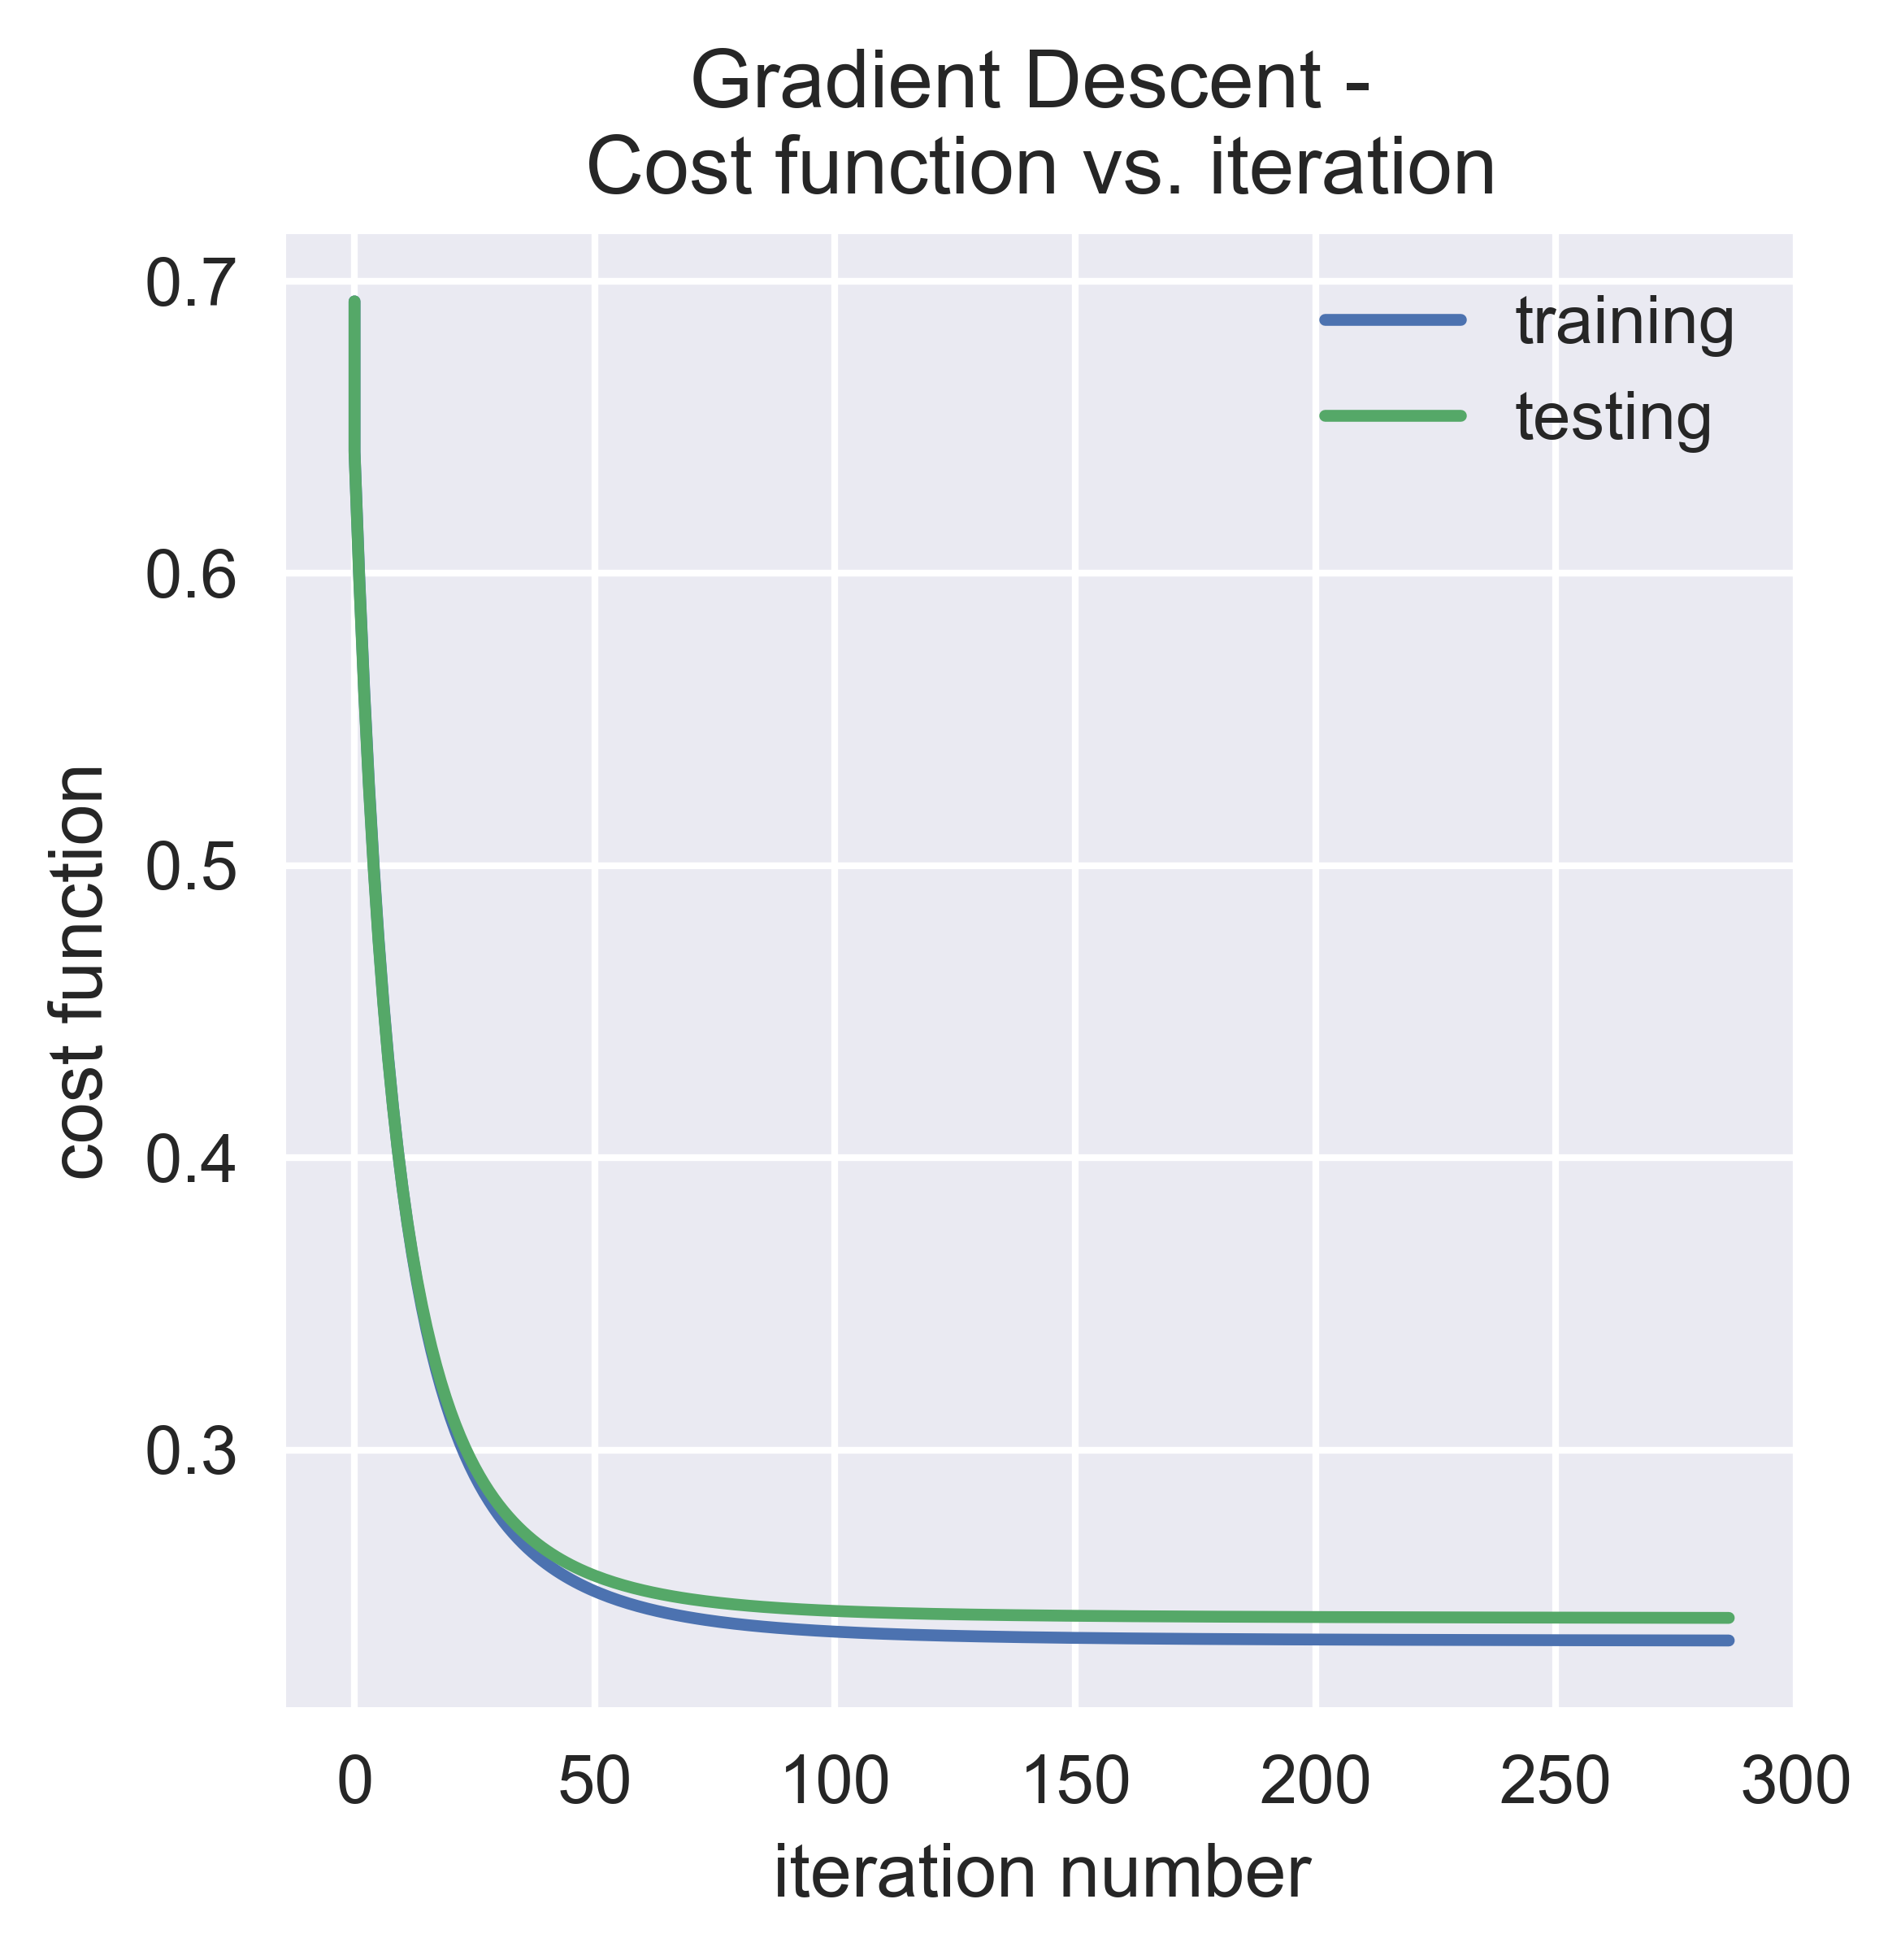

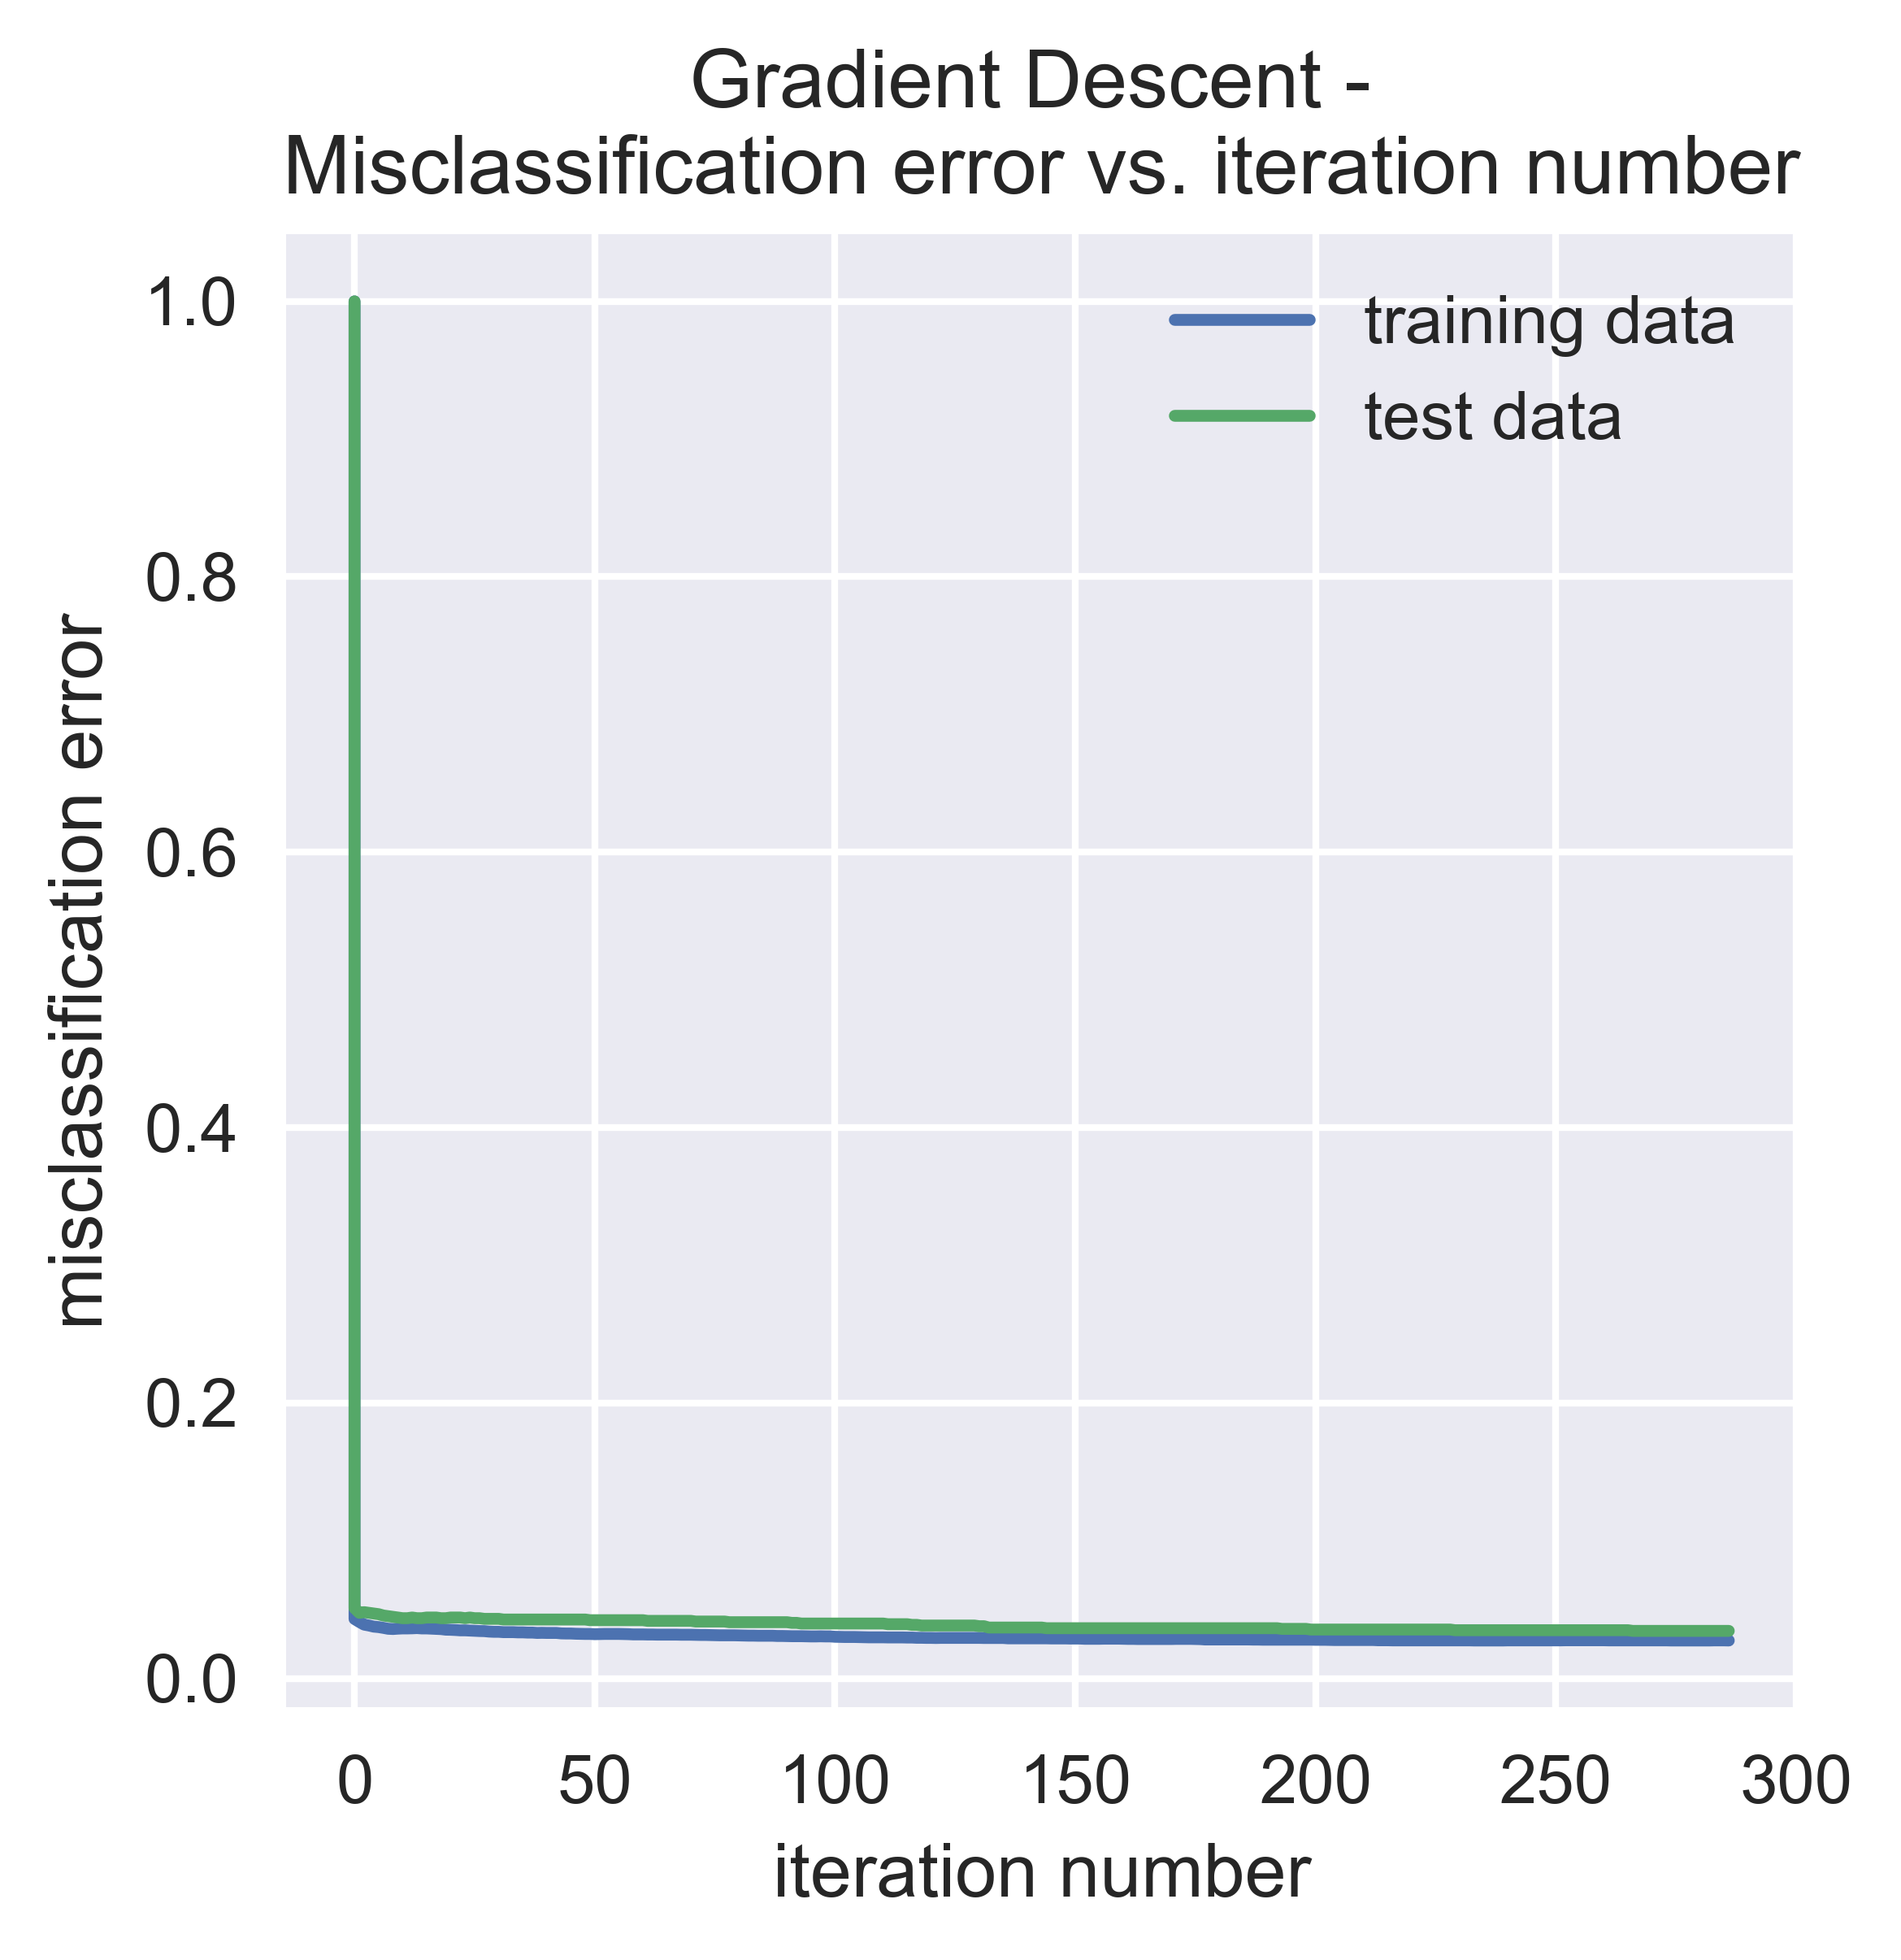

In [17]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Gradient Descent - \n')

### stochastic gradient descent - 1 example

In [71]:
batch_size = 1
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = SGD(x_train_c,labels_train_c,x_test_c,labels_test_c,lambda_val,batch_size)

the value of j train is 0.6931471805599452
the value of j train is 0.7229658081577198
the value of j train is 0.7974338231651028
the value of j train is 0.43701772333325595
the value of j train is 0.3832266606236483
the value of j train is 0.3753975916304973
the value of j train is 0.34166145636380524
the value of j train is 0.3560818461164954
the value of j train is 0.3746277014201661
the value of j train is 0.4081815440544242
the value of j train is 0.4190317061972574
the value of j train is 0.43912000307410315
the value of j train is 0.3031225295611044
the value of j train is 0.29490857813765214
the value of j train is 0.3374426432784631
the value of j train is 0.3439546059057616
the value of j train is 0.3571252819725482
the value of j train is 0.2923949925745853
the value of j train is 0.29464340176717907
the value of j train is 0.28453129493010254
the value of j train is 0.2782113597227798
the value of j train is 0.277252612633791
the value of j train is 0.27574415942878866
the v

the value of j train is 0.2521452551995088
the value of j train is 0.24941014144524193
the value of j train is 0.24899565534348522
the value of j train is 0.26236294174009955
the value of j train is 0.26726913602623464
the value of j train is 0.2629225233603616
the value of j train is 0.27167119346982443


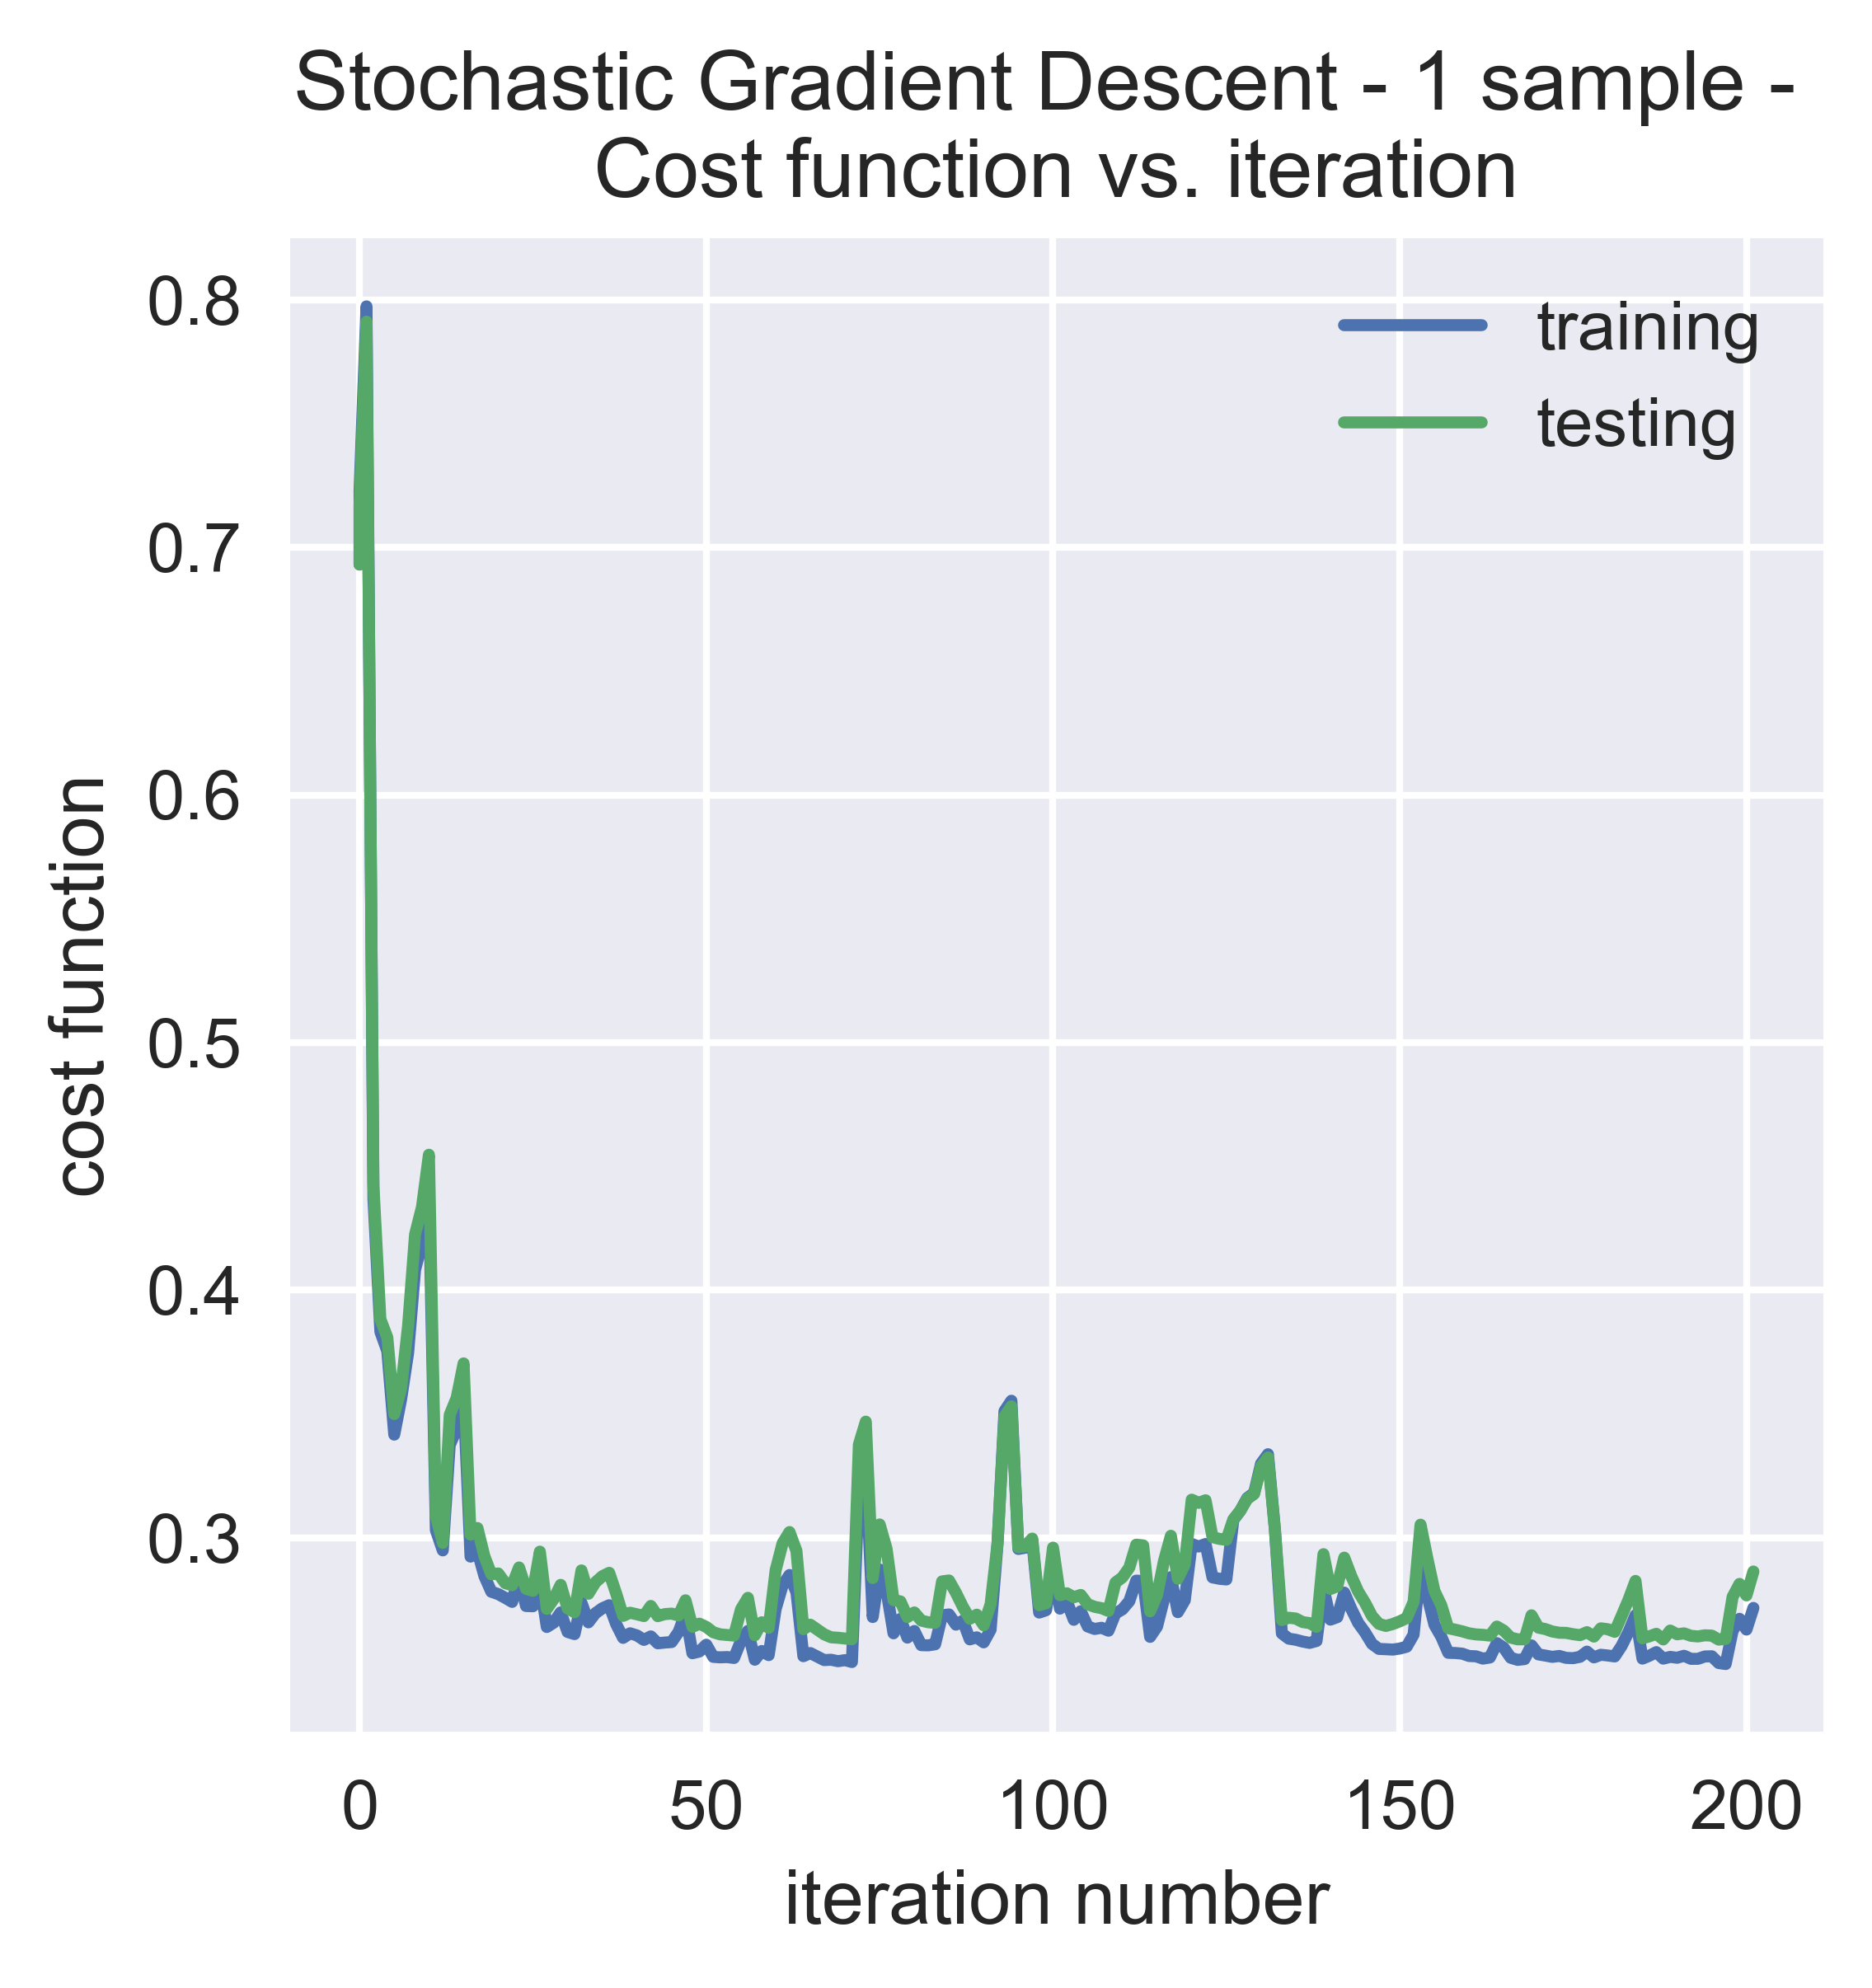

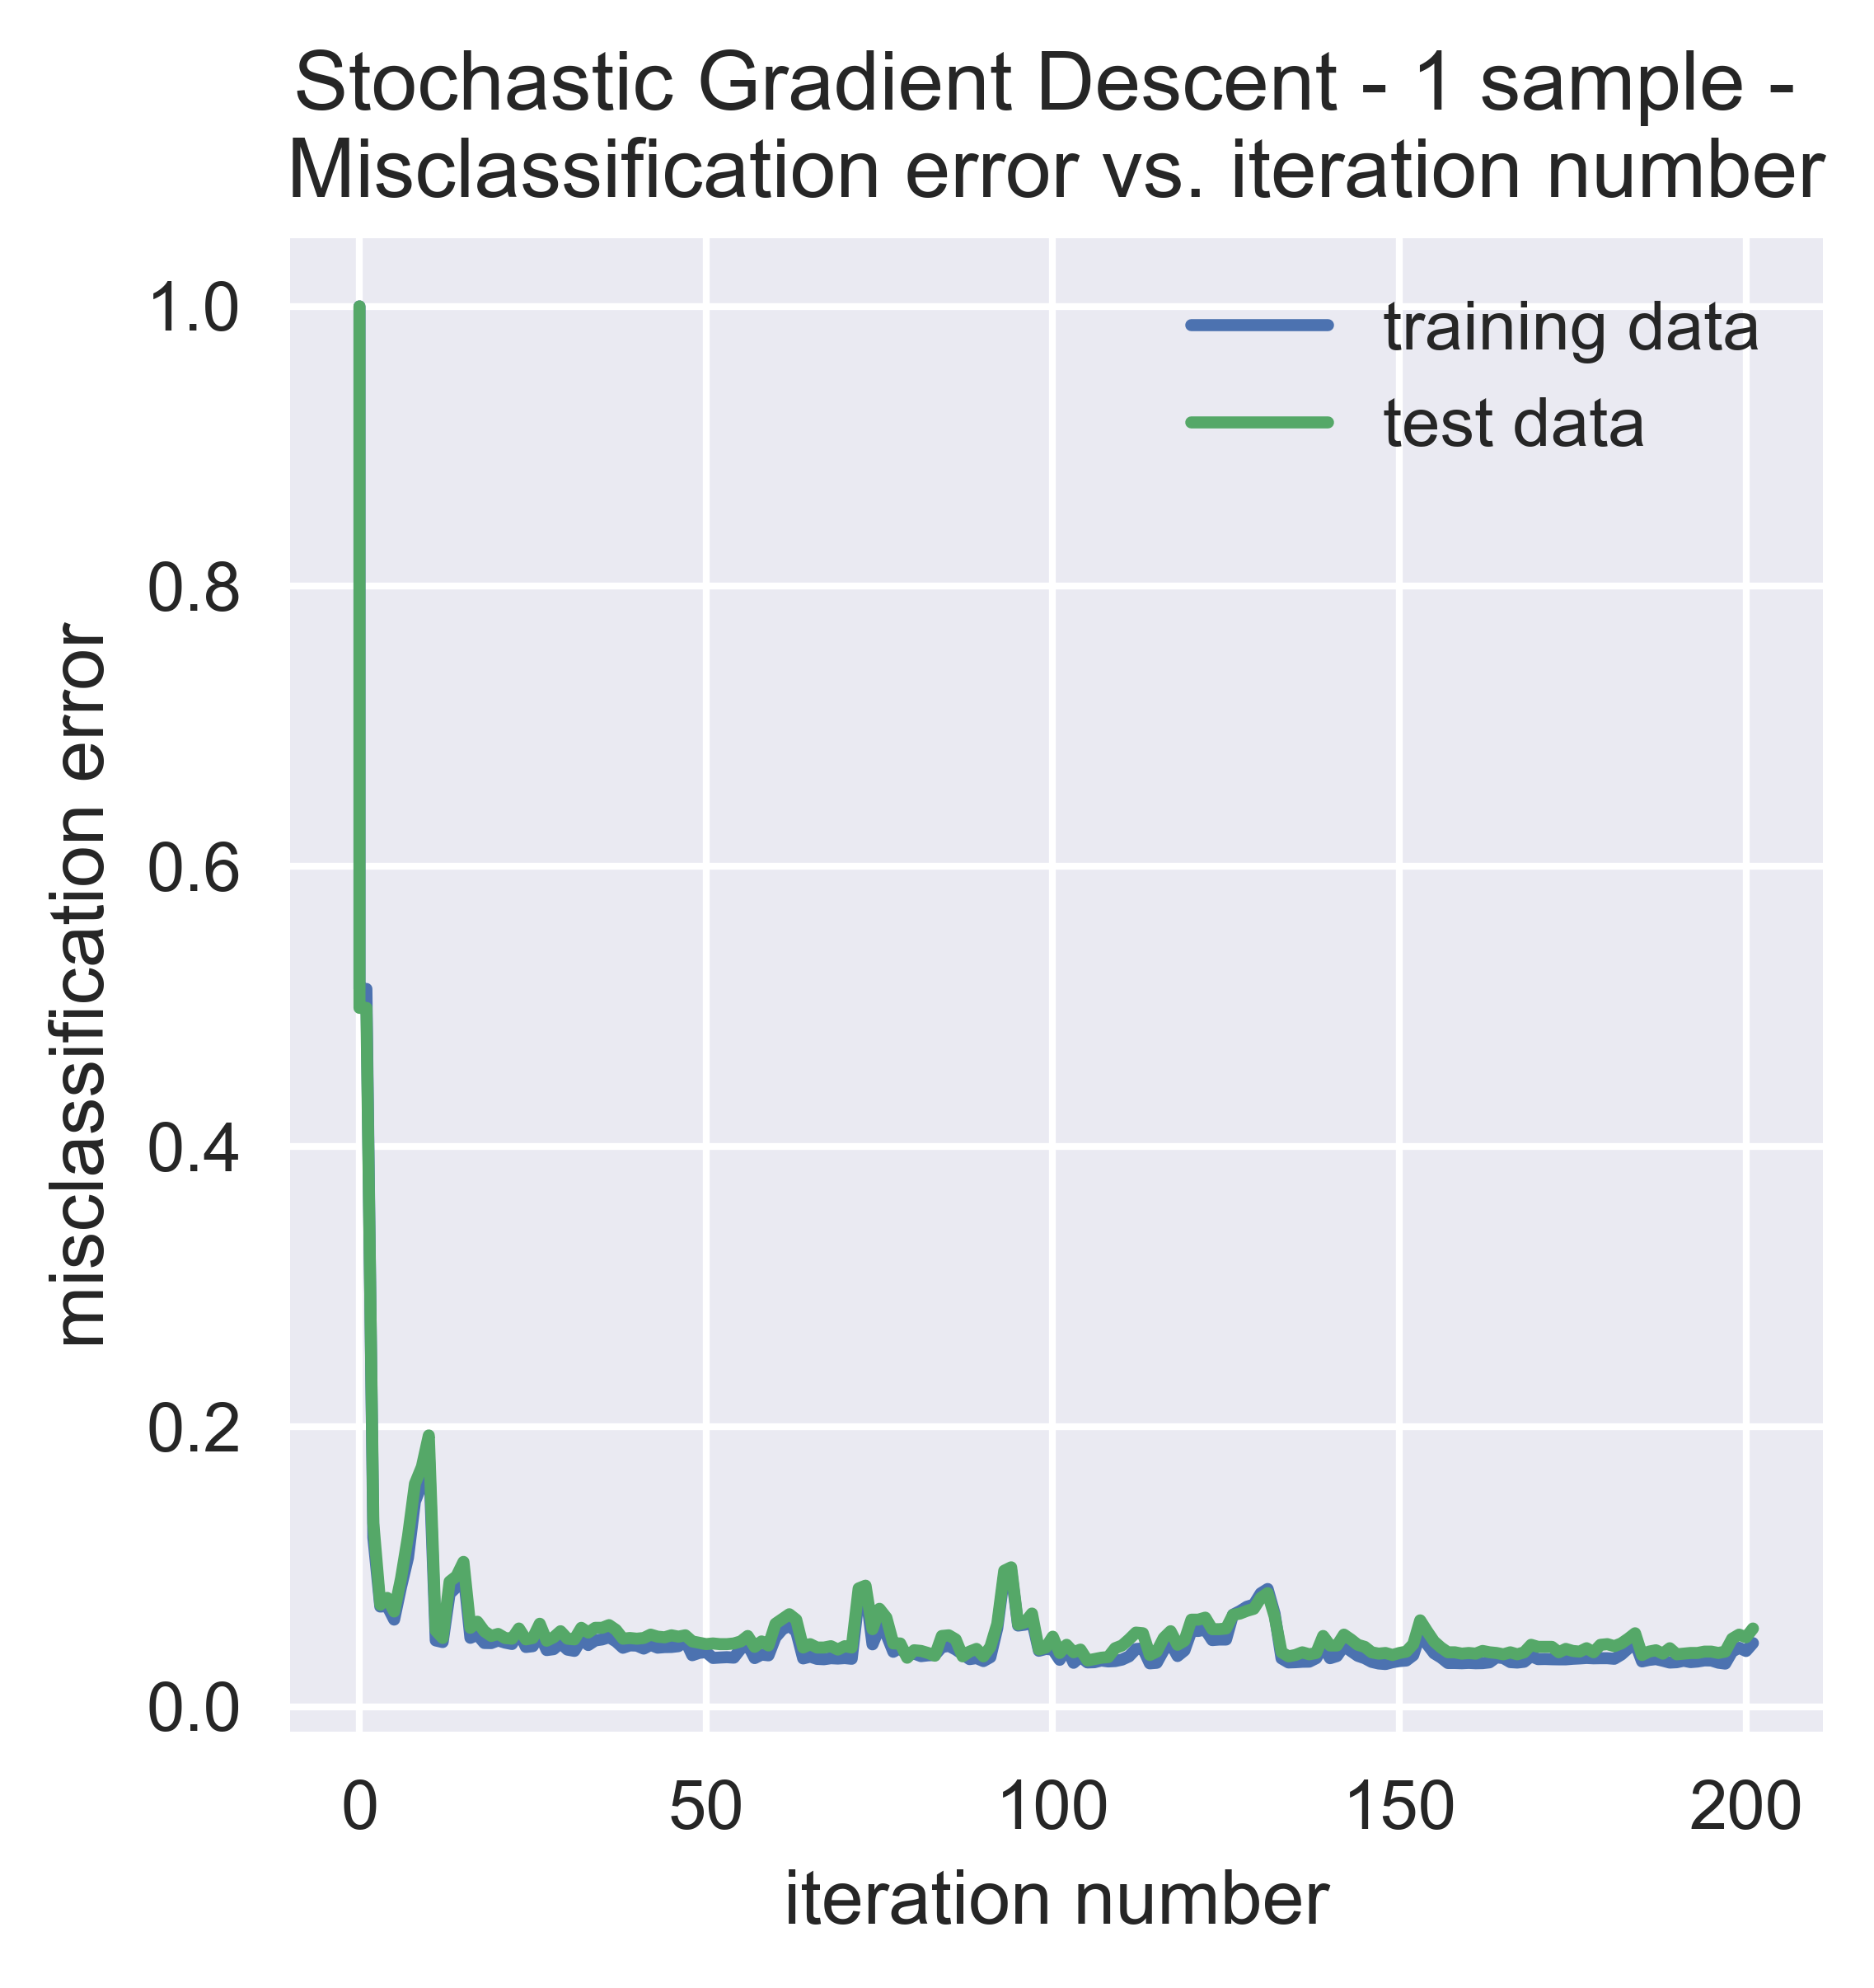

In [72]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Stochastic Gradient Descent - 1 sample - \n')

### stochastic gradient descent - batch size 100

In [73]:
batch_size = 100 
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = SGD(x_train_c,labels_train_c,x_test_c,labels_test_c,lambda_val,batch_size)

the value of j train is 0.6931471805599452
the value of j train is 0.605717298391247
the value of j train is 0.5437815491450894
the value of j train is 0.49415619903594327
the value of j train is 0.4537082814916563
the value of j train is 0.4227133335036779
the value of j train is 0.3965997168572006
the value of j train is 0.3773441743979776
the value of j train is 0.3605108761908564
the value of j train is 0.34560850867034043
the value of j train is 0.3328417463122988
the value of j train is 0.3216830840071553
the value of j train is 0.3126274737487908
the value of j train is 0.30481368538111797
the value of j train is 0.298077345337838
the value of j train is 0.293205778410681
the value of j train is 0.28733133961657337
the value of j train is 0.28306563353159364
the value of j train is 0.2784084496047542
the value of j train is 0.2747782919441226
the value of j train is 0.2715160342469021
the value of j train is 0.2685204407781806
the value of j train is 0.2660066630575328
the value

the value of j train is 0.2350127747280878
the value of j train is 0.23504528906033667
the value of j train is 0.23492822505549876
the value of j train is 0.23497283597997953
the value of j train is 0.23494740370815853
the value of j train is 0.23493937702169723
the value of j train is 0.2349346008045644
the value of j train is 0.2351947964396672
the value of j train is 0.23630166533184743
the value of j train is 0.23568666818464348
the value of j train is 0.23628544632942086
the value of j train is 0.2352267246356255


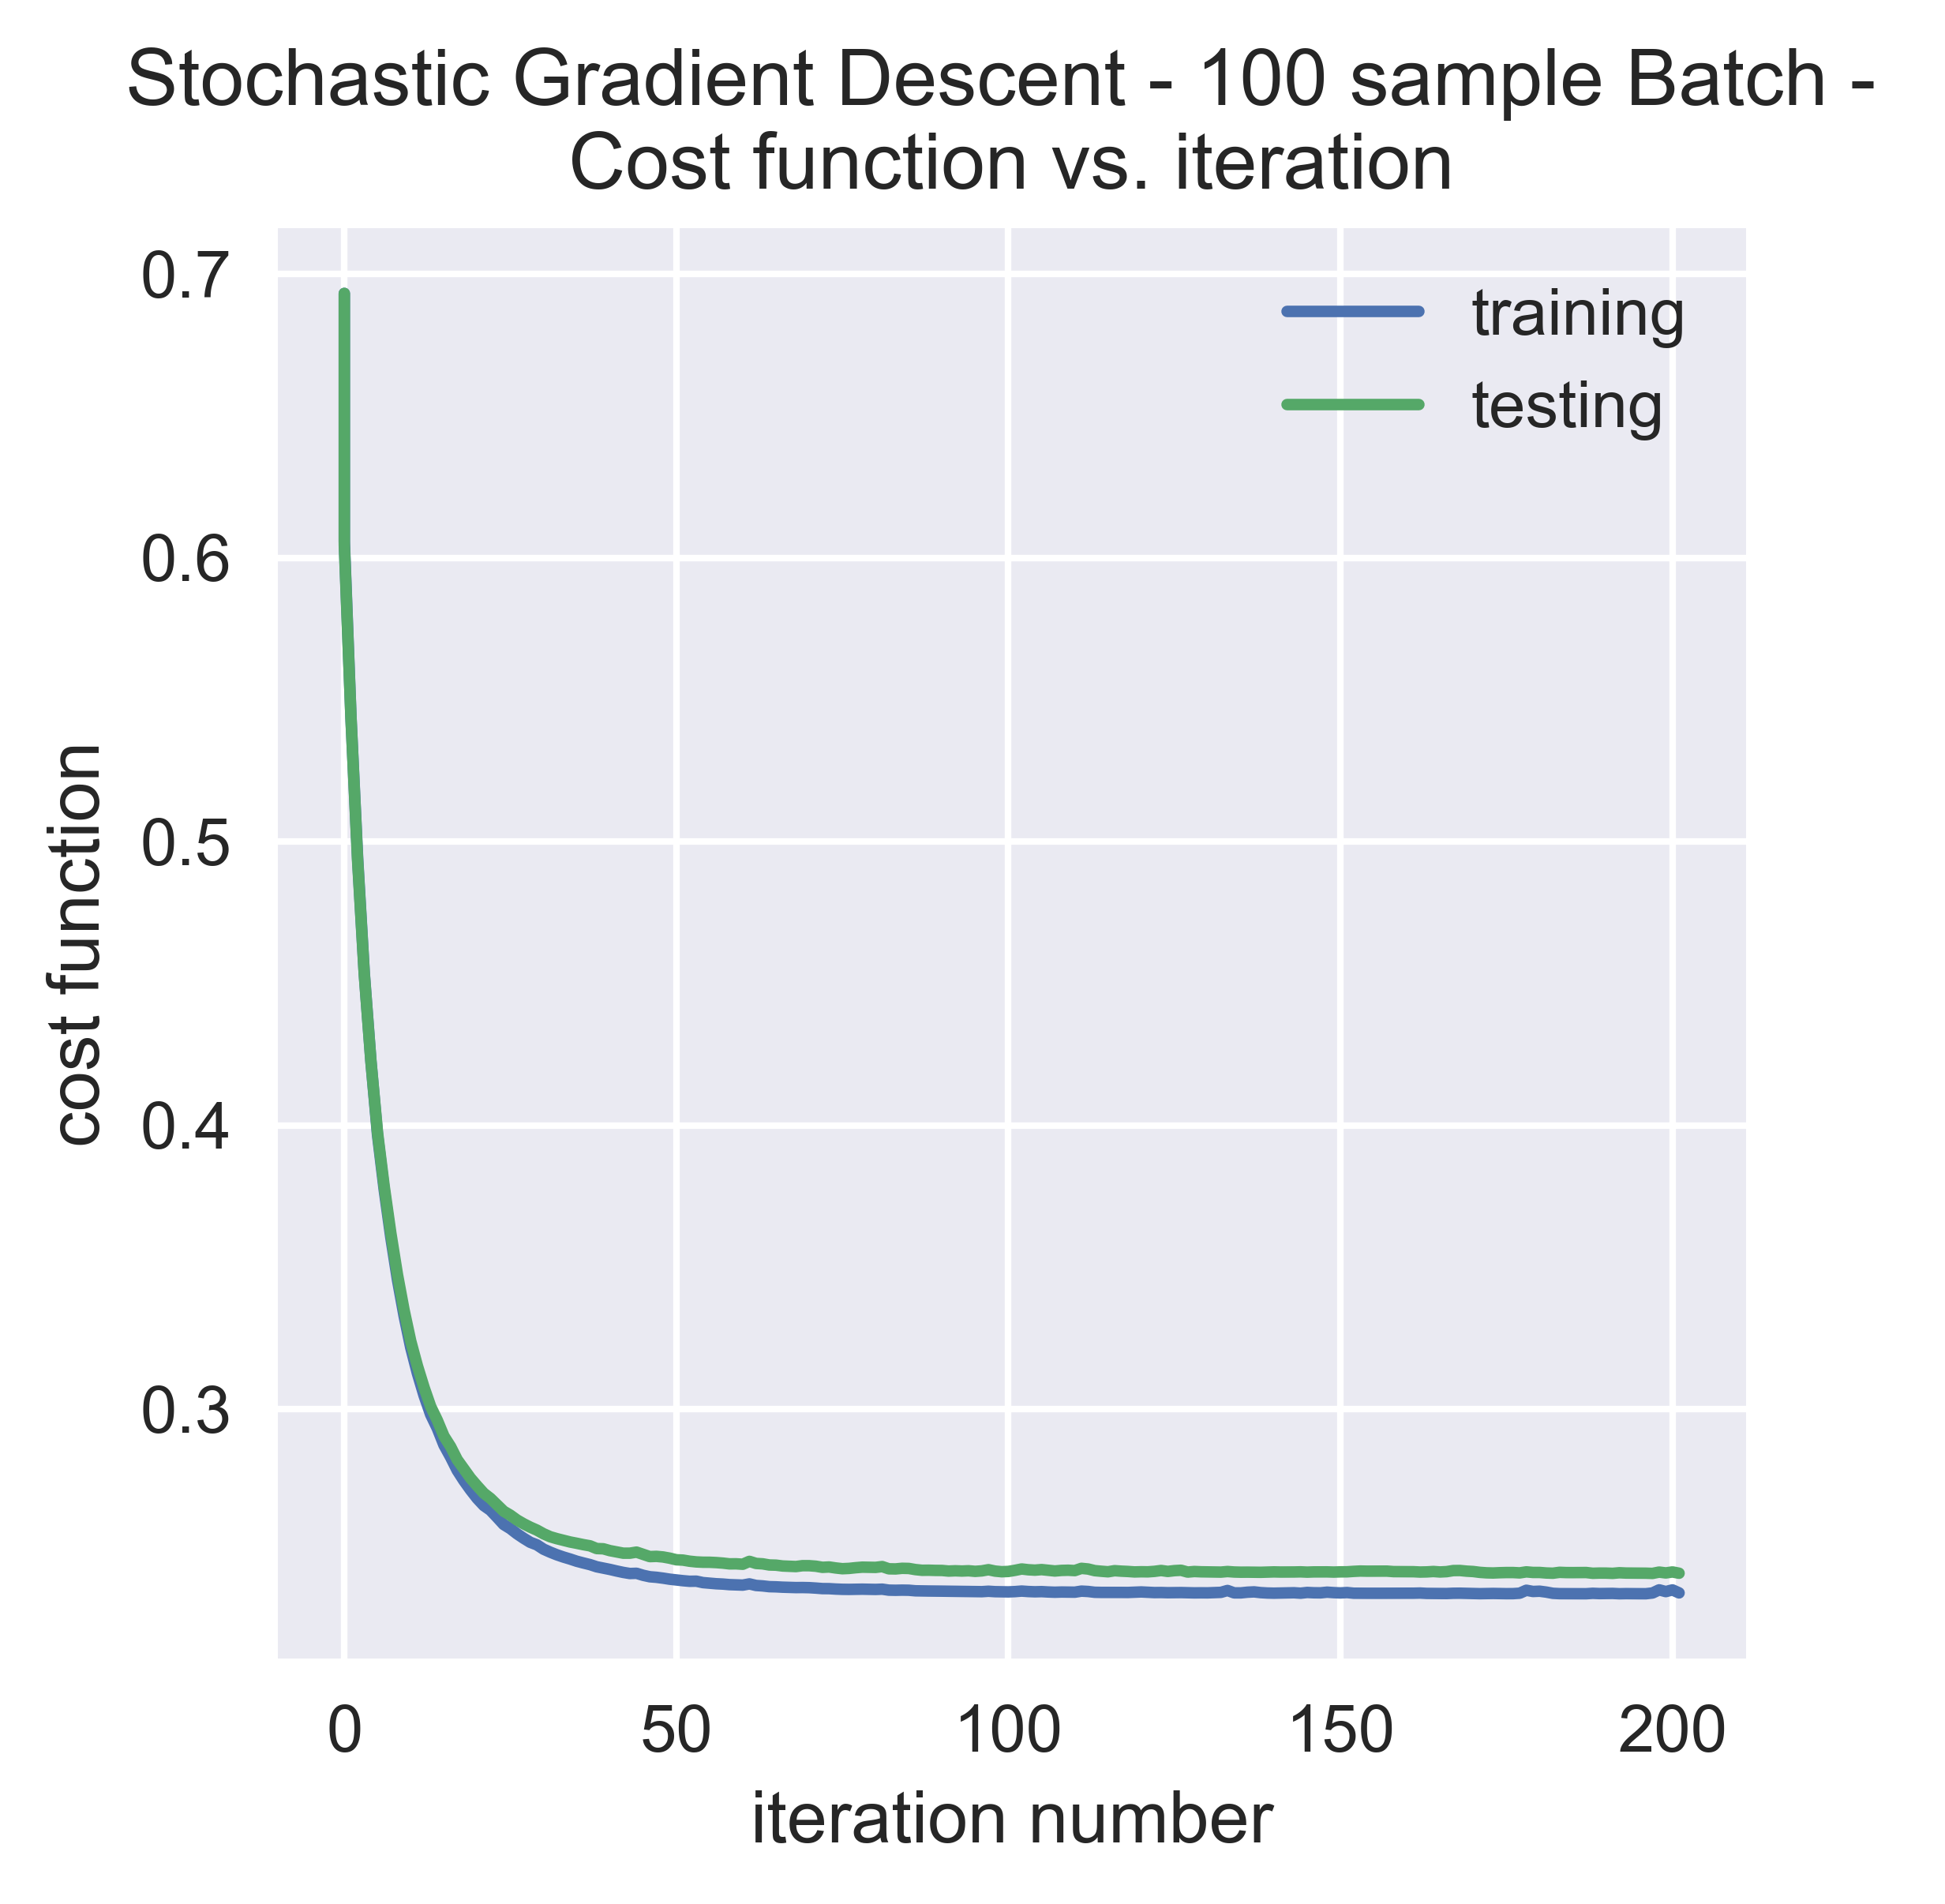

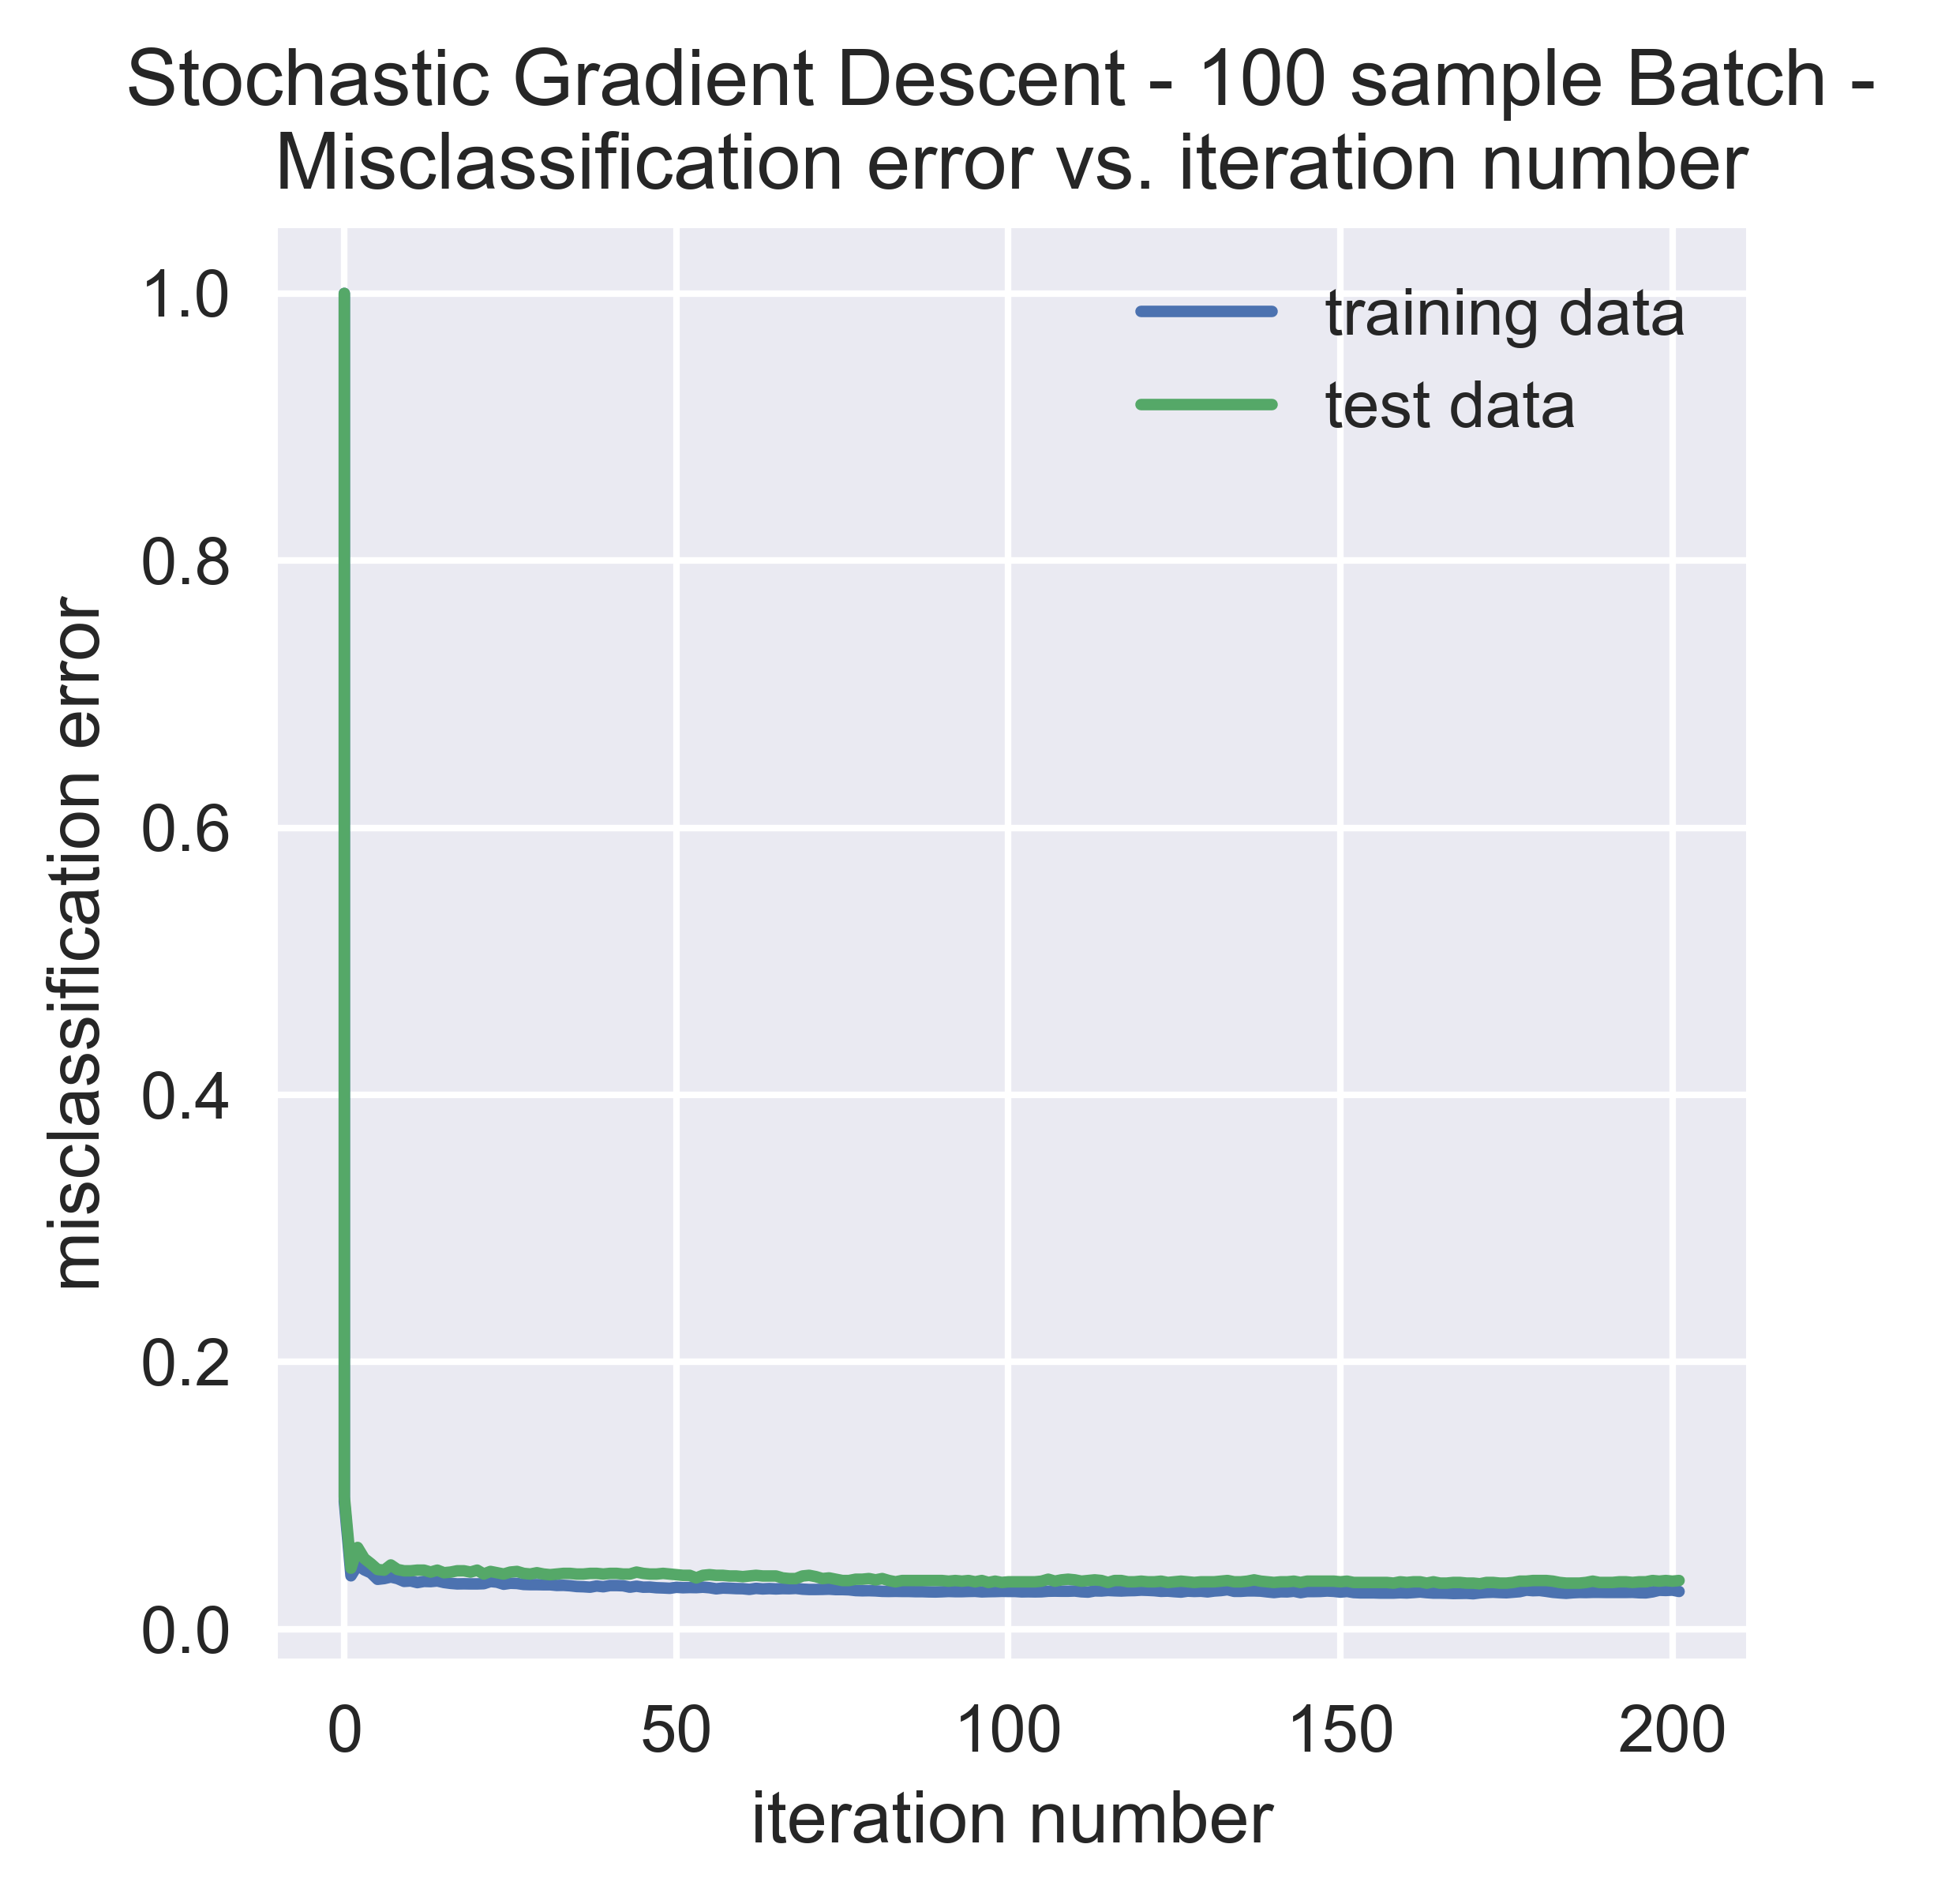

In [74]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Stochastic Gradient Descent - 100 sample Batch - \n')

### newton's method 

In [48]:
j_train_vec,j_test_vec,w_vec,b_vec,k_vec,test_classify_vec,train_classify_vec = newton_method(x_train_c,labels_train_c,x_test_c,labels_test_c,lambda_val)

the value of j train is 0.6931471805599452
the value of j train is 0.2770841950644773
0.0134271437518
the value of j train is 0.23766775727977937
0.0052461701467
the value of j train is 0.23487475169931332
0.00173836919585


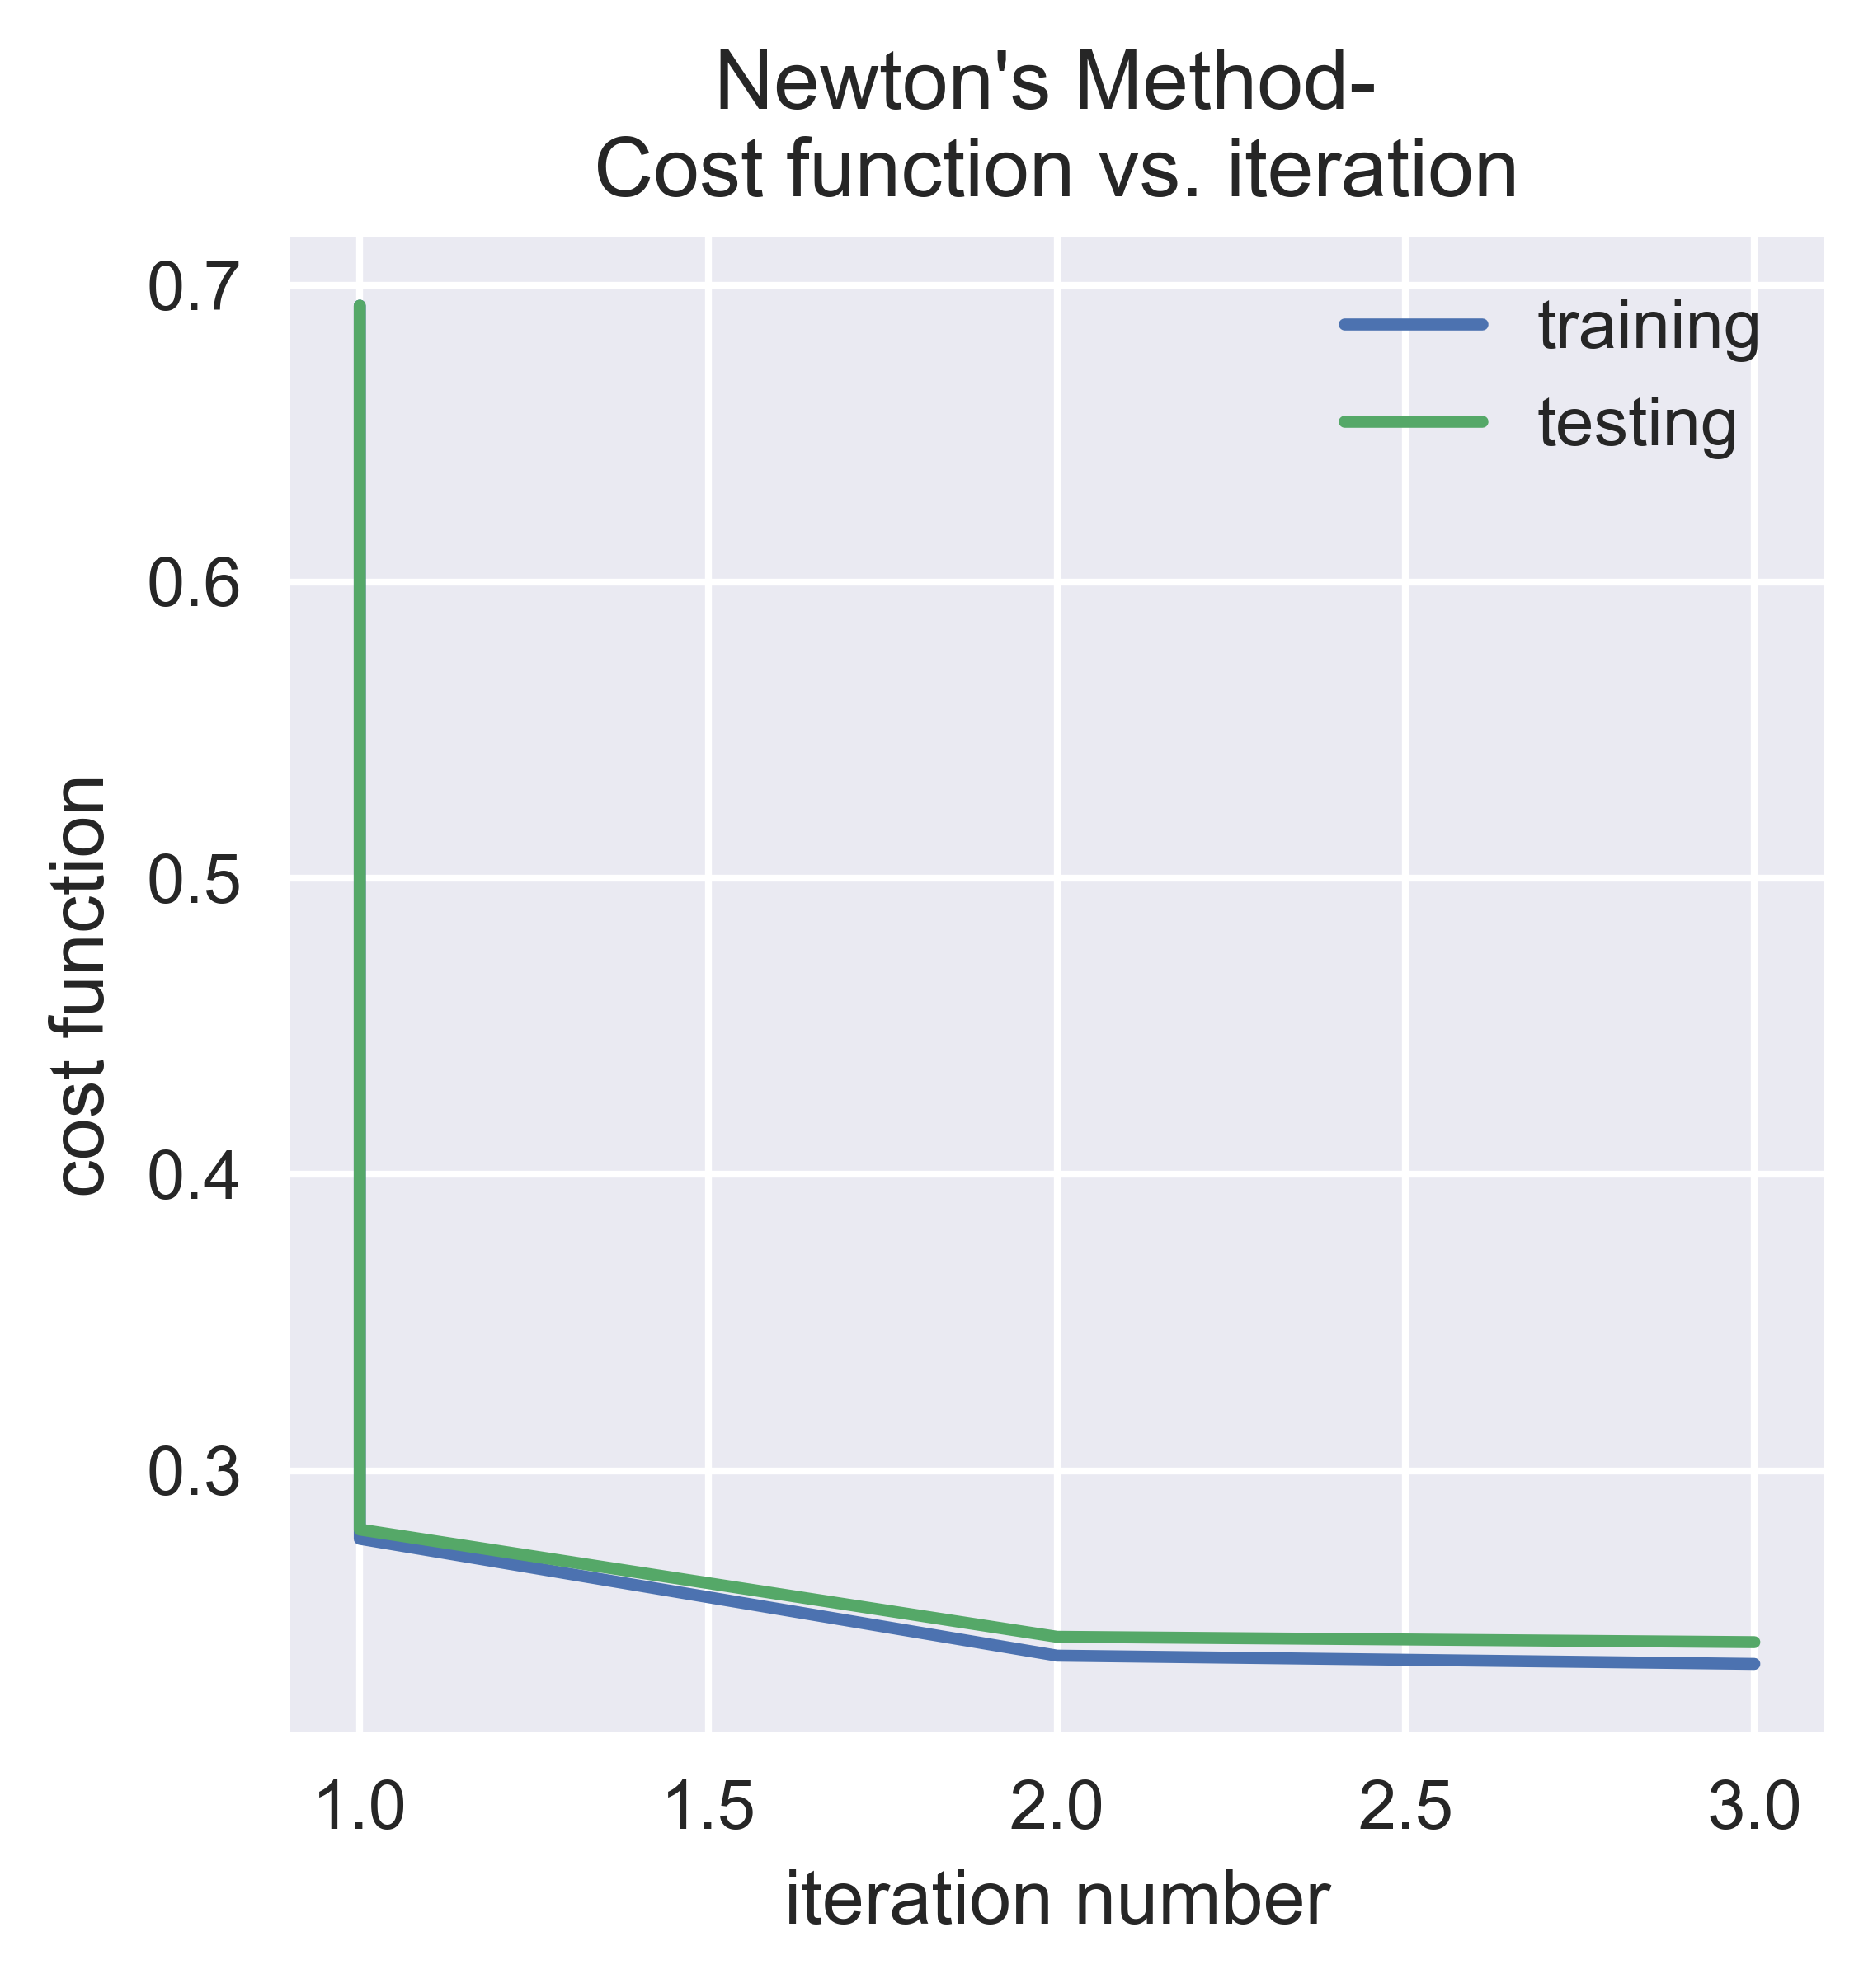

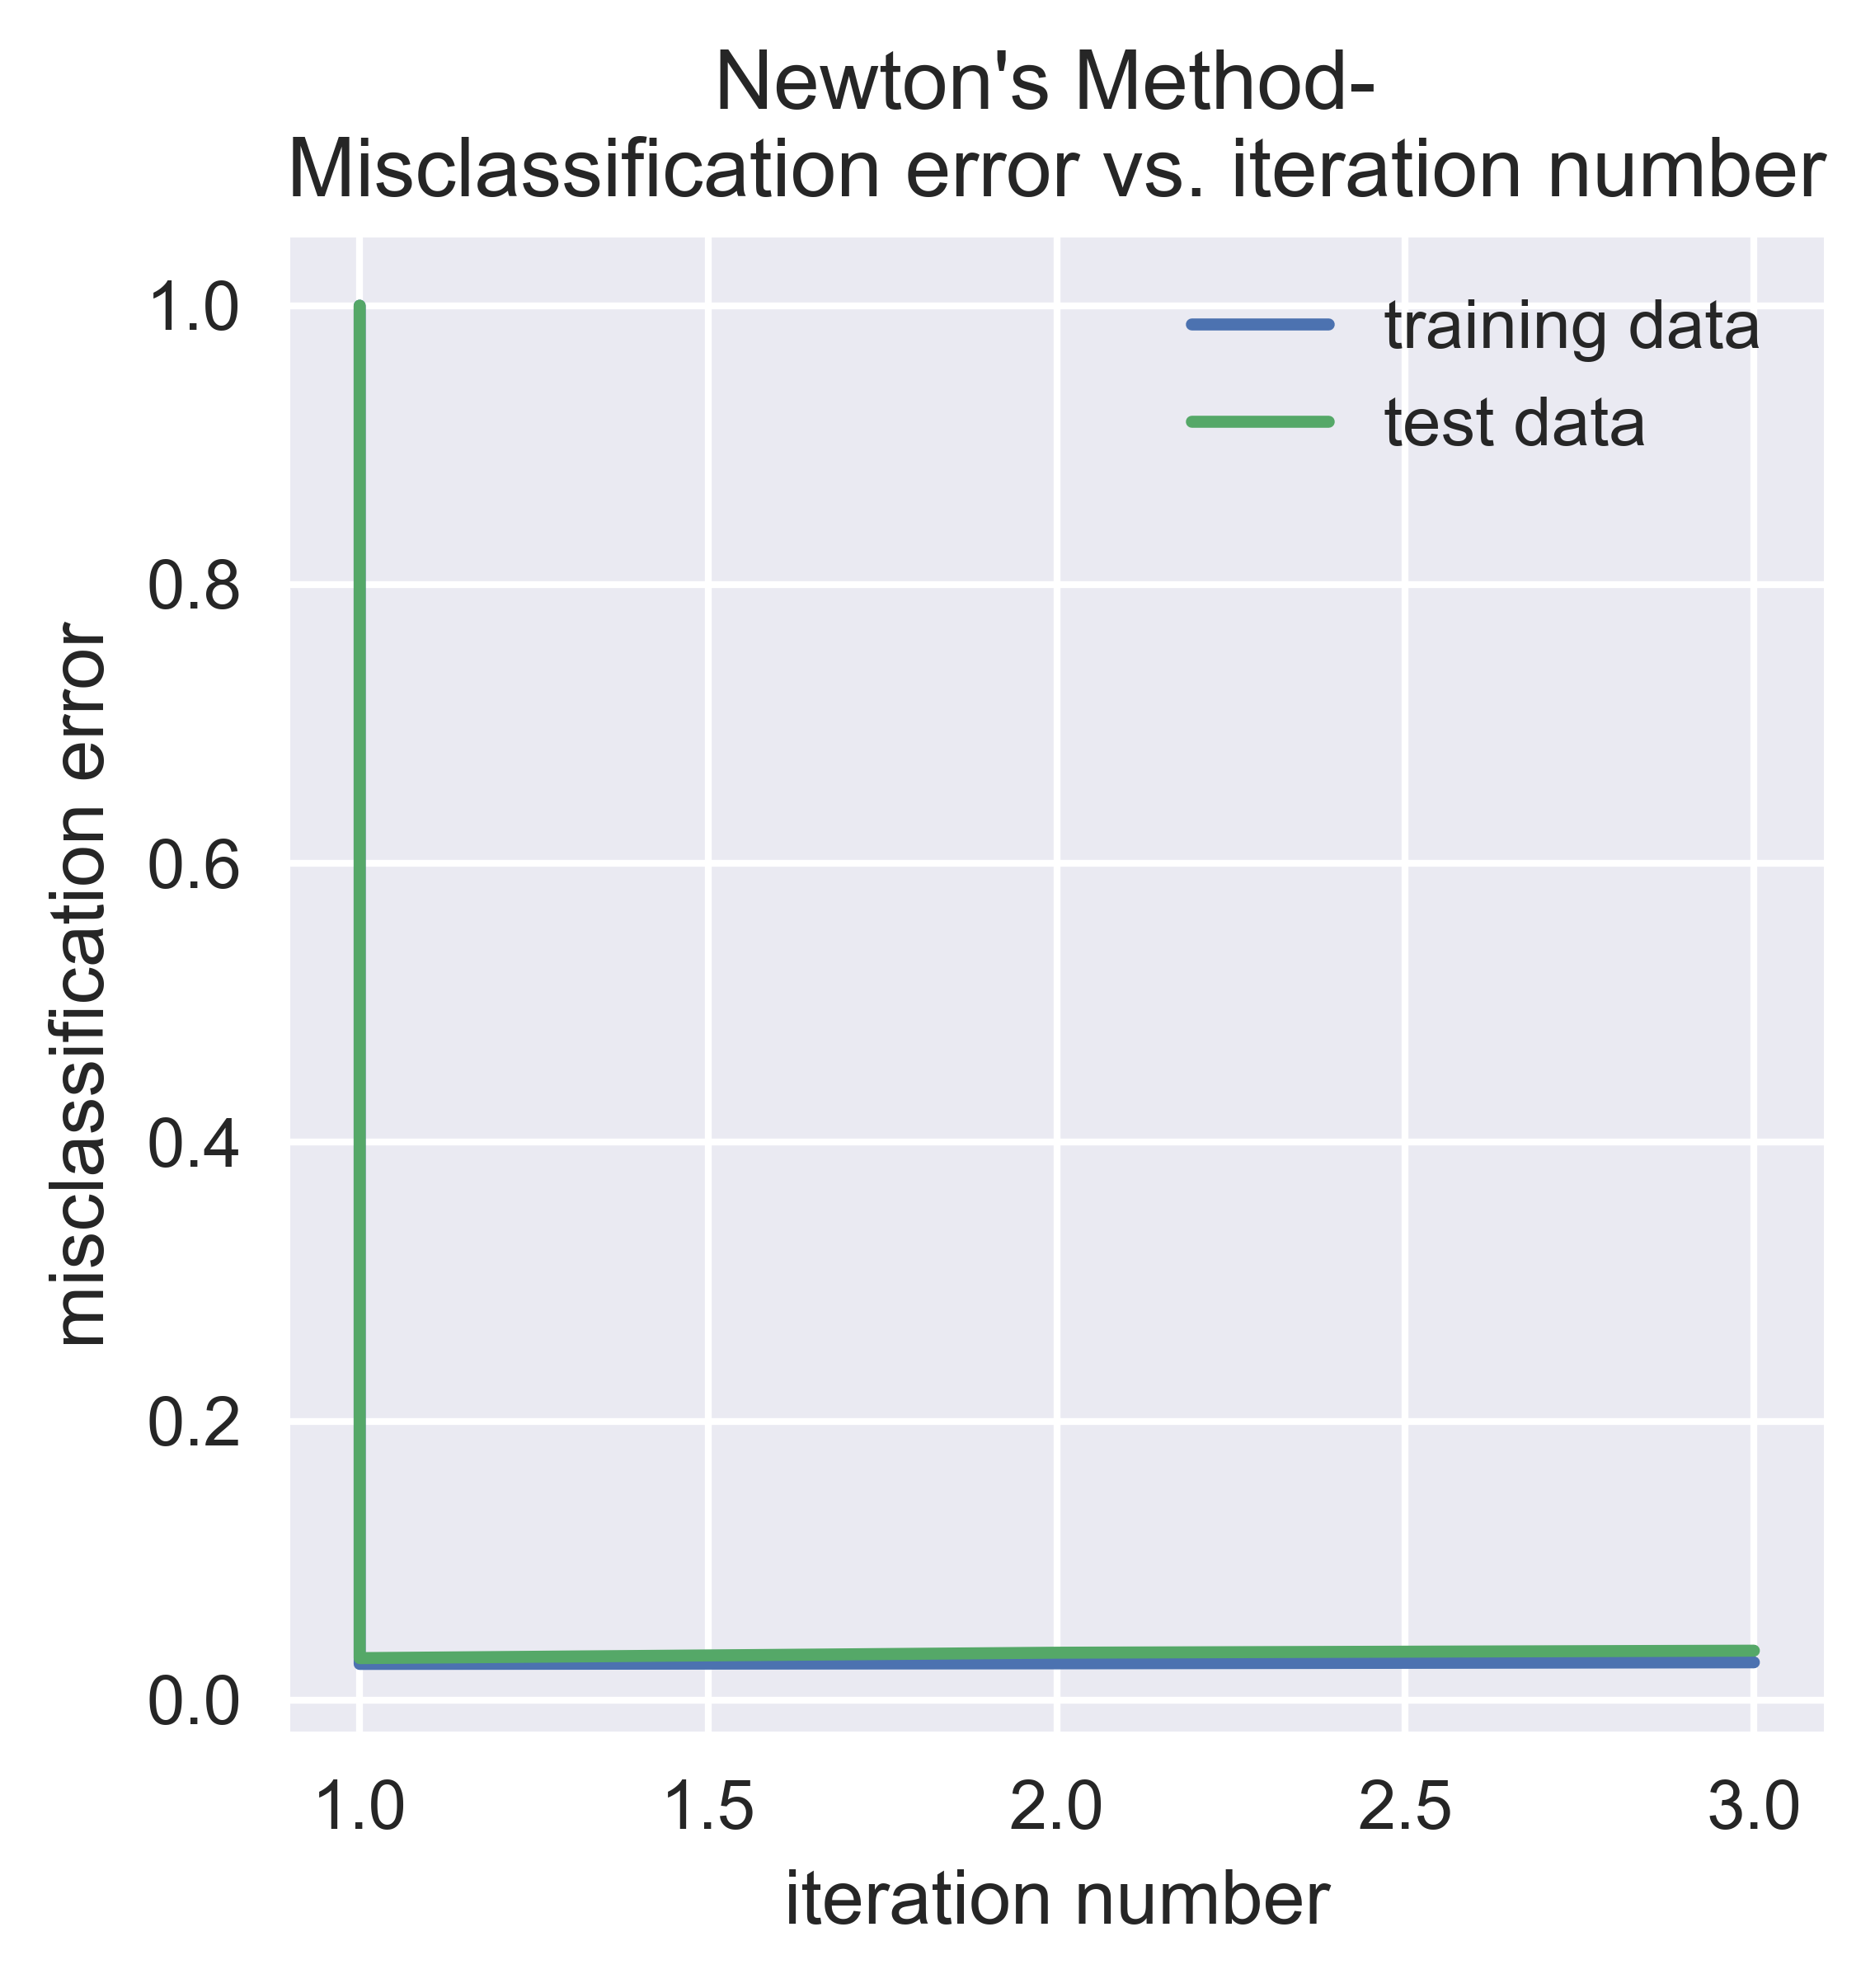

In [49]:
plot_objective_train_test(k_vec,j_train_vec,j_test_vec,train_classify_vec,test_classify_vec,'Newton\'s Method- \n')

### batch

### this is scratch below here

In [ ]:
X = x_train_c
y = labels_train_c
X_test = x_test_c
y_test = labels_test_c

not_conv = True
j_train_vec = []
j_test_vec = []
w_vec = []
b_vec = []
k_vec = []
train_classify_vec = []
test_classify_vec = []

k = 0
#step_size = 1e-3
step_size = 5e-2
criteria_conv = 2e-4

w = np.zeros((np.shape(X)[1],))
b = 0
n = np.shape(X)[0]
#mu_vec = np.zeros((np.shape(X)[0],))
#cost_mu = np.zeros((np.shape(X)[0],))
#range_vec = np.arange(len(mu_vec))
j_prev = 0

while not_conv:
    ##### training part 
    #mu_vec = [1/(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
    #cost_mu = [(1+np.exp(-y[i]*(b+np.dot(X[i,:].T,w)))) for i in range_vec]
    mu_vec = 1/(1+np.exp(-y.T*(b+np.dot(X,w)))) 
    cost_mu = 1+np.exp(-y.T*(b+np.dot(X,w)))
     
    #g_w = (1/n)*np.dot(X.T,(mu_vec - y)) + 2*lambda_val*w
    #g_b = (1/n)*np.sum(mu_vec-y)
    
    g_w = (1/n)*(np.dot(X.T,(-y*(1-mu_vec)))) + 2*lambda_val*w
    g_b = (1/n)*np.sum(-y*(1-mu_vec))
    
    j_train = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)
    ####### testing part
    
    mu_vec = 1/(1+np.exp(-y_test.T*(b+np.dot(X_test,w)))) 
    cost_mu = 1+np.exp(-y_test.T*(b+np.dot(X_test,w)))
    
    j_test = (1/n)*(np.sum(np.log(cost_mu))) + lambda_val*np.dot(w.T,w)

    # 
    w_new = w - step_size*g_w
    b_new = b - step_size*g_b
    
    w_vec.append(w)
    b_vec.append(b)

    delta_w = np.abs(w-w_old)
    delta_b = np.abs(b-b_old)

    #w = np.array(w)
    w = copy.copy(w_new)
    b = copy.copy(b_new)

    k_vec.append(k)
    j_train_vec.append(j_train)
    j_test_vec.append(j_test)
    
    #### classificaiton
    train_signed = (b+np.dot(X,w))
    test_signed = (b+np.dot(X_test,w))

    train_data_class = np.sign(train_signed)
    test_data_class = np.sign(test_signed)

    train_classify_error_vec = [train_data_class != y]
    test_classify_error_vec = [test_data_class != y_test]
    
    train_classify_error = np.sum(train_classify_error_vec)/n
    test_classify_error = np.sum(test_classify_error_vec)/n
    
    train_classify_vec.append(train_classify_error)
    test_classify_vec.append(test_classify_error)
    
    # check convergence
    if ((1/n)*np.sum(delta_w))<criteria_conv and k>1:
        not_conv = False

    else:
        not_conv = True
        k += 1

    print('the value of j train is {}'.format(j_train))

    #print('the value of delta_w is {}'.format(delta_w))
    #print(mu_vec)
    #print(not_conv)


In [ ]:
plt.figure()
plt.plot(k_vec,j_train_vec,label='training')
plt.plot(k_vec,j_test_vec,label='testing')
plt.xlabel('iteration number')
plt.ylabel('cost function')
plt.title('Cost function vs. iteration')
plt.legend()
index = np.argmin(j_train_vec)
k_best = k_vec[index]
w_best = w_vec[index]


plt.figure()
plt.plot(k_vec,train_classify_vec,label='training data')
plt.plot(k_vec,test_classify_vec,label='test data')
plt.xlabel('iteration number')
plt.ylabel('misclassification error')
plt.title('Misclassification error vs. iteration number')
plt.legend()


In [ ]:
np.diag([1,2,3])

In [37]:
a= [1,2,3,4,5]

In [44]:
a[:-2]

[1, 2, 3]